<center><p style="font-size:30px;font-family:consolas">SOUNDCLOUD - Exploratory Data Analysis</p></center>

<table style="width:100%">
  <tr>
    <th>Name-ID</th>
    <th>Task</th>
    <th>Distribution</th>
  </tr>
  <tr>
    <td>20127597 - Bùi Tấn Phương (Leader)</td>
    <td>Collect data, summary all .ipynb files</td>
    <td>25%</td>
  </tr> 
  <tr>
    <td>19127084 - Phạm Anh Tuấn</td>
    <td>EDA tracks dataset, running code</td>
    <td>25%</td>
  </tr>
  <tr>
    <td>19127237 - Trương Minh Nhựt</td>
    <td>EDA playlists dataset</td>
    <td>25%</td>
  </tr>
  <tr>
    <td>20127567 - Lê Nguyễn Bình Nam</td>
    <td>EDA users dataset</td>
    <td>25%</td>
  </tr>
</table>

In [ ]:
!pip install selenium
!pip install webdriver-manager

We have to install:
- **Selenium**: use for working with browse automatically and interactively
- **Webdriver-manager**: use for install Chronium without installing Chronium before

In [2]:
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

import csv

from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')

# 1. Data collection: 
In this session, we will collect soundcloud data about 3 entities: users, playlists, tracks. We have 3 data criteria: Adequate, quality, efficiency.  
From above goals, we have a data collection process:
- Step 1: Collect playlists from search page. Besides, we crawl url of users who created these playlists and max 5 tracks in each playlist to represent this playlist music style.
- Step 2: From tracks url we crawl in previous step, we crawl tracks data from tracks pages. Similarly, we also get url of users who are author of these tracks.
- Step 3: Crawl users data in users pages from urls we have crawled.
- Step 4: Write collected data into .csv file

## 1.1. Initialize some global variable and ultility function: 

Function `initialize_driver` use for initialize some Chrome options (ex: not load image, headless mode,...) and open specified url.

In [2]:
# Initialize webdriver
def initialize_driver(url):
    chrome_options = webdriver.ChromeOptions()
    prefs={"profile.managed_default_content_settings.images": 2, 'disk-cache-size': 4096 }
    chrome_options.add_experimental_option("prefs", prefs) # Manage image loading and run on disk cache
    chrome_options.add_argument("--headless") # Runs Chrome in headless mode
    chrome_options.add_argument('--no-sandbox') # Bypass OS security model
    chrome_options.add_argument('--disable-dev-shm-usage') # overcome limited resource problems
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
    driver.get(url)        
    return driver

`scrollWebpage` use for scrolling webside

In [3]:
def scrollWebpage(n_times, driver):
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    for _ in range(n_times):
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        
        # Wait to load page
        time.sleep(2)
        
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        
        # compare 2 height (to check whether reach the end of website)
        if new_height == last_height:
            # webpage may be loading
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
        
        # update height
        last_height = new_height

below function use for accept cookies if it exists

In [4]:
def accept_cookies(driver):
    try:
        WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH,
                                                    '//button[@id="onetrust-accept-btn-handler"]')))
    except Exception as err:
        pass
    else:
        ck = driver.find_element(By.XPATH, '//button[@id="onetrust-accept-btn-handler"]') # accept cookies
        driver.execute_script("arguments[0].click();", ck)

convert string to number (because almost crawled data from web are string type)

In [5]:
def string2number(numstr):
    if numstr == "Repost" or numstr == "Like":
        return 0

    numstr = numstr.replace(',', '')
    mul = 1
    if numstr[-1] == 'K':
        numstr = numstr.replace('K', '')
    elif numstr[-1] == 'M':
        numstr = numstr.replace('M', '')
        mul = 1000000
    elif numstr[-1] == 'B':
        numstr = numstr.replace('B', '')
        mul = 1000000000
    return int(float(numstr) * mul)

Function `write_csv_file` use for writing a list data to csv file

In [6]:
def write_csv_file(filename, header, content):
    with open(filename, 'w', encoding='utf-8-sig', newline='') as file:
        writter = csv.writer(file, delimiter=',')
        writter.writerow(header)
        for l in content:
            writter.writerow(l)

Initialize some common variables for some task (sleep time, number of thread, assign, storage,...)

In [7]:
# Initialize some ultilities
sleep = 3
maxWorkers = 15
searchStr = 'abcdefghijklmnoprstuvwxyz0123456789'
base_link = 'https://www.soundcloud.com'

In [8]:
# Some variable for assigning and storing
users_id = dict() # url : id
users_list = [] # all data
users_id_assign = 0 # use for assigning id

playlists_id = dict()
playlists_list = []
playlists_id_assign = 0

tracks_id = dict() # url : [id, trackname]
tracks_crawl = set()
tracks_list = []
tracks_id_assign = 0

## 1.2. Crawling users: 
This function will crawl user data from soundcloud user page

In [9]:
def CrawlUsersData_from_page(url):
    driver = initialize_driver(url)
    accept_cookies(driver)
    page_source = driver.page_source
    driver.close()
    driver.quit()
    soup = BeautifulSoup(page_source, 'html.parser')

    if soup.find('span', class_="verifiedBadge userDropbar__verifiedBadge"):
        confirm_owner = 'Yes'
    else:
        confirm_owner = 'Not yet'

    detail_name = soup.find('h3', 
                            class_="profileHeaderInfo__additional g-type-shrinkwrap-block theme-dark g-type-shrinkwrap-large-secondary")
    if detail_name:
        detail_name = detail_name.text.strip().encode('utf-8').decode('utf-8')
    else:
        detail_name = ''
        
    country = soup.find('h3', 
                        class_='profileHeaderInfo__additional g-type-shrinkwrap-block theme-dark g-type-shrinkwrap-large-secondary sc-mt-1x')
    if country:
        country = country.text.strip().encode('utf-8').decode('utf-8')
    else:
        country = ''
    
    user_stat = soup.find_all('a', class_="infoStats__statLink sc-link-light sc-link-primary")
    user_followers = user_following = user_tracks = 0
    if user_stat:
        user_followers = string2number(user_stat[0]['title'].strip().split(' ')[0].replace(',', ''))
        user_following = string2number(user_stat[1]['title'].strip().split(' ')[1].replace(',', ''))
        user_tracks = string2number(user_stat[2]['title'].strip().split(' ')[0].replace(',', ''))

    users_list.append([users_id[url][0], users_id[url][1], url, confirm_owner, detail_name, 
                        country, user_followers, user_following, user_tracks])

## 1.3. Crawling playlists: 
This function will crawl playlists data from soundcloud search page. Though data is not detail, but it is still enough for analysing

In [10]:
def CrawlPlaylistData_from_search(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')

    global playlists_id_assign
    global tracks_id_assign
    global users_id_assign
    # print(len(playlists))

    playlists = soup.find_all('div', class_='sound__body')
    for playlist in playlists:
        playlist_base = playlist.find('a', class_='sc-link-primary soundTitle__title sc-link-dark sc-text-h4')
        playlist_url = base_link + playlist_base['href']
        if playlist_url in playlists_id.keys():
            continue
        
        playlist_id = playlists_id_assign
        playlists_id[playlist_url] = playlist_id
        playlists_id_assign += 1
        
        playlist_name = playlist_base.text.strip().encode('utf-8').decode('utf-8')

        playlist_time = playlist.find('time', class_="relativeTime sc-text-secondary sc-text-captions")['datetime']

        playlist_tag = playlist.find('span', class_='sc-truncate sc-tagContent')
        if playlist_tag:
            playlist_tag = playlist_tag.text.strip().encode('utf-8').decode('utf-8')
        else:
            playlist_tag = ''

        playlist_like = string2number(playlist.find('button', class_="sc-button-like sc-button-secondary sc-button sc-button-small sc-button-responsive").text)

        playlist_repost = string2number(playlist.find('button', class_="sc-button-repost sc-button-secondary sc-button sc-button-small sc-button-responsive").text)

        # crawl user
        playlist_username = playlist.find('span', class_='soundTitle__usernameText').text.strip().encode('utf-8').decode('utf-8')
        playlist_user_url = base_link + playlist.find('span', class_='soundTitle__usernameText').parent['href']

        if playlist_user_url not in users_id:
            user_id = users_id_assign
            users_id[playlist_user_url] = [user_id, playlist_username]
            users_id_assign += 1

        else:
            user_id = users_id[playlist_user_url][0]

        # crawl tracks
        playlist_tracks = playlist.find_all('div', class_='compactTrackListItem sc-media sc-border-light-bottom clickToPlay m-interactive m-playable')
        playlist_tracks_id = []
        cnt_crawl_track = 0
        for track in playlist_tracks:
            track_url = base_link + track.find('span',
                                               class_='compactTrackListItem__trackTitle sc-text-primary sc-text-h4')\
                                                ['data-permalink-path'].split('?')[0]
            if track_url not in tracks_id.keys():
                track_id = tracks_id_assign
                tracks_id[track_url] = track_id
                tracks_id_assign += 1
                if cnt_crawl_track < 5:
                    tracks_crawl.add(track_url)
                    cnt_crawl_track += 1
            elif track_url not in tracks_crawl and cnt_crawl_track < 5:
                track_id = tracks_id[track_url]
                tracks_crawl.add(track_url)
                cnt_crawl_track += 1
            else:
                track_id = tracks_id[track_url]
                
            playlist_tracks_id.append(track_id)
        
        playlists_list.append([playlist_id, playlist_name, playlist_url, user_id, playlist_username, playlist_time, playlist_tag, 
                                playlist_like, playlist_repost, len(playlist_tracks_id), playlist_tracks_id])

## 1.4. Crawling tracks:
Below function will crawl tracks data from soundcloud tracks page. It crawl as much as possible

In [11]:
def CrawlingTracksData_from_page(url):
    driver = initialize_driver(url)
    
    global users_id_assign
    accept_cookies(driver)
    page_source = driver.page_source
    driver.close()
    driver.quit()
    soup = BeautifulSoup(page_source, 'html.parser')

    track_name = soup.find('h1', class_="soundTitle__title sc-font g-type-shrinkwrap-inline g-type-shrinkwrap-large-primary theme-dark")\
                    .text.strip().encode('utf-8').decode('utf-8')
    
    track_user = soup.find('a', class_="sc-link-secondary")
    track_username = track_user.text.strip().encode('utf-8').decode('utf-8')
    track_user_url = base_link + track_user['href']
    if track_user_url not in users_id:
        users_id[track_user_url] = [users_id_assign, track_username]
        track_user_id = users_id_assign
        users_id_assign += 1
    else:
        track_user_id = users_id[track_user_url][0]
    
    track_time = soup.find('time', class_='relativeTime')['datetime']

    track_tag = soup.find('a', class_="sc-tag sc-tag-large")
    if track_tag:
        track_tag = track_tag.text.strip().encode('utf-8').decode('utf-8')
    else:
        track_tag = ''

    track_comments = soup.find('span', class_="commentsList__actualTitle")
    if track_comments:
        track_comments = string2number(track_comments.text.strip().split(' ')[0])
    else:
        track_comments = 0
    
    track_stat = soup.find('ul', class_="soundStats sc-ministats-group listenEngagement__stats sc-ministats-group-right")
    track_stat = track_stat.find_all('li', class_='sc-ministats-item')
    track_play = track_like = track_repost = 0
    for stat in track_stat:
        num, stat_type = stat['title'].strip().split()
        num = int(num.replace(',', ''))
        if stat_type in ['play', 'plays']:
            track_play = num
        elif stat_type in ['like', 'likes']:
            track_like = num
        else:
            track_repost = num
    
    tracks_list.append([tracks_id[url], track_name, url, track_user_id, track_username, track_time,
                        track_tag, track_play, track_like, track_comments, track_repost])    

## 1.5. Crawling (start crawling):

**Step 1:**

In [12]:
playlists_search_str = [base_link + '/search/sets?q=' + c for c in searchStr]

def get_playlists(url):
    driver = initialize_driver(url)
    accept_cookies(driver)
    scrollWebpage(5, driver)

    try:
        more_tracks_button = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.XPATH, '//a[@class="compactTrackList__moreLink sc-link-light sc-link-primary sc-border-light sc-text-h4"]')))
    except Exception as err:
        print('Something went wrong!')
    else:
        for bt in more_tracks_button:
            driver.execute_script("arguments[0].click();", bt)
    
    page_source = driver.page_source
    driver.close()
    driver.quit()
    CrawlPlaylistData_from_search(page_source)

In [ ]:
with ThreadPoolExecutor(max_workers=maxWorkers) as executor:
    executor.map(get_playlists, playlists_search_str)

**Step 2:**

In [ ]:
with ThreadPoolExecutor(max_workers=maxWorkers) as executor:
    executor.map(CrawlingTracksData_from_page, tracks_crawl)

**Step 3:**

In [ ]:
crawl_users_url = list(users_id.keys())
with ThreadPoolExecutor(max_workers=maxWorkers) as executor:
    executor.map(CrawlUsersData_from_page, crawl_users_url)

**Step 4:**

- Write to user.csv

In [ ]:
user_header = ['user_id', 'username', 'user_url', 'confirm_owner', 'detail_name',
               'country', 'user_followers', 'user_following', 'track']
write_csv_file('./SoundcloudData/user.csv', user_header, users_list)

- Write to playlist.csv

In [ ]:
playlist_header = ['playlist_id', 'playlist_name', 'playlist_url', 'owner_id', 'username', 
                   'playlist_time', 'playlist_tag', 'like', 'repost', 'size', 'tracks']
write_csv_file('./SoundcloudData/playlist.csv', playlist_header, playlists_list)

- Write to track.csv

In [ ]:
track_header=['track_id', 'track_name', 'url', 'user_id', 'username', 'datetime',
              'track_tag', 'track_play', 'track_like', 'track_repost']
write_csv_file('./SoundcloudData/track.csv', track_header, tracks_list)

# 2. Exploratory Data Analisys:

## 2.1. Users:

### 2.1.1. EDA:

#### Store data to dataframe

In [2]:
user_df = pd.read_csv('./SoundcloudData/user.csv', encoding='utf-8')
user_df.head()

,user_id,username,user_url,confirm_owner,detail_name,country,user_followers,user_following,track
0,8,FitnusLife,https://www.soundcloud.com/fitnuslife,Not yet,NaN,NaN,2540,6,1
1,4,jcool19_,https://www.soundcloud.com/jig-saw19,Not yet,NaN,NaN,3,0,1
2,0,lihcogine,https://www.soundcloud.com/eliana-cogine,Not yet,Eliana Cogine,NaN,9982,1,0
3,7,Khushpreet Singh,https://www.soundcloud.com/khushpreet-singh-6,Not yet,Khushpreet Singh,NaN,2947,110,0
4,3,Rehan Khan 55,https://www.soundcloud.com/rehan-khan-55,Not yet,Rehan Khan,NaN,8509,14,0


We think we should let user_id as index

In [3]:
user_df = user_df.sort_values('user_id').set_index('user_id')
user_df.head()

,username,user_url,confirm_owner,detail_name,country,user_followers,user_following,track
user_id,,,,,,,,
0,lihcogine,https://www.soundcloud.com/eliana-cogine,Not yet,Eliana Cogine,NaN,9982,1,0
1,lonesomejupiter,https://www.soundcloud.com/butterxly,Not yet,NaN,☁️,18069,4,2
2,Mighty,https://www.soundcloud.com/mightyj-1,Not yet,Jordan Robinson,"Los Angeles, United States",11683,540,0
3,Rehan Khan 55,https://www.soundcloud.com/rehan-khan-55,Not yet,Rehan Khan,NaN,8509,14,0
4,jcool19_,https://www.soundcloud.com/jig-saw19,Not yet,NaN,NaN,3,0,1


#### How many rows and column in dataset?

In [4]:
n_rows, n_cols = user_df.shape
print(f'User dataframe shape: {n_rows} rows and {n_cols} columns')

User dataframe shape: 3777 rows and 8 columns


#### Is data duplicated?

In [5]:
any(user_df.duplicated())

False

#### What is the meaning of each columns?

**Mean of each column:**
- username: name of user
- user_url: url direct to user page
- confirm_owner: soundcloud has confirmed that the profile is the authentic presence of the public figure or global brand it represents
- detail_name: more detail name
- country: country or more detail about city of user
- user_followers: number of users follow this user
- user_following: number of users who this user follow
- track: number of tracks which user have  

#### What is the datatype of each column? Are there any columns with datatypes that are not suitable for further processing?

In [6]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3777 entries, 0 to 3777
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        3777 non-null   object
 1   user_url        3777 non-null   object
 2   confirm_owner   3777 non-null   object
 3   detail_name     2363 non-null   object
 4   country         2249 non-null   object
 5   user_followers  3777 non-null   int64 
 6   user_following  3777 non-null   int64 
 7   track           3777 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 265.6+ KB


*Confirm owner* should be convert to 0, 1 for analysing easilier.

#### Are there any columns have missing value?

In [7]:
miss_num = user_df.isnull().sum(axis=0).sort_values(ascending=False)
miss_percent = miss_num / n_rows * 100

pd.DataFrame({'Count':miss_num, '%':miss_percent})

,Count,%
country,1528,40.455388
detail_name,1414,37.437119
username,0,0.000000
user_url,0,0.000000
confirm_owner,0,0.000000
user_followers,0,0.000000
user_following,0,0.000000
track,0,0.000000


Because of *country* and *detail_name* dtypes, we will replace missing value with string 'Missing'

#### What is the distribution of data?

In [8]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
user_df.describe()

,user_followers,user_following,track
count,3777.0000,3777.0000,3777.0000
mean,130099.5340,137.8332,131.5780
std,672682.2896,318.2870,2484.3637
min,0.0000,0.0000,0.0000
25%,159.0000,1.0000,2.0000
50%,1599.0000,16.0000,15.0000
75%,15302.0000,101.0000,47.0000
max,10112575.0000,2007.0000,150674.0000


In [9]:
user_df.describe(include='O')

,username,user_url,confirm_owner,detail_name,country
count,3777,3777,3777,2363,2249
unique,3768,3777,2,2350,1208
top,Emmanuel Piolet,https://www.soundcloud.com/eliana-cogine,Not yet,Hanan Gobran,"Los Angeles, United States"
freq,2,1,2883,4,63


---

### 2.1.2. Preprocessing

In [10]:
user_df.confirm_owner = user_df.confirm_owner.replace({'Yes' : 1, 'Not yet' : 0})
user_df[['country', 'detail_name']] = user_df[['country', 'detail_name']].fillna('Missing')
user_df[['country', 'detail_name']] = user_df[['country', 'detail_name']].astype('str')
user_df.head()

,username,user_url,confirm_owner,detail_name,country,user_followers,user_following,track
user_id,,,,,,,,
0,lihcogine,https://www.soundcloud.com/eliana-cogine,0,Eliana Cogine,Missing,9982,1,0
1,lonesomejupiter,https://www.soundcloud.com/butterxly,0,Missing,☁️,18069,4,2
2,Mighty,https://www.soundcloud.com/mightyj-1,0,Jordan Robinson,"Los Angeles, United States",11683,540,0
3,Rehan Khan 55,https://www.soundcloud.com/rehan-khan-55,0,Rehan Khan,Missing,8509,14,0
4,jcool19_,https://www.soundcloud.com/jig-saw19,0,Missing,Missing,3,0,1


In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3777 entries, 0 to 3777
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        3777 non-null   object
 1   user_url        3777 non-null   object
 2   confirm_owner   3777 non-null   int64 
 3   detail_name     3777 non-null   object
 4   country         3777 non-null   object
 5   user_followers  3777 non-null   int64 
 6   user_following  3777 non-null   int64 
 7   track           3777 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 265.6+ KB


---

### 2.1.3. EDA (cont)

#### Let's take a look at the distribution plot of numeric features

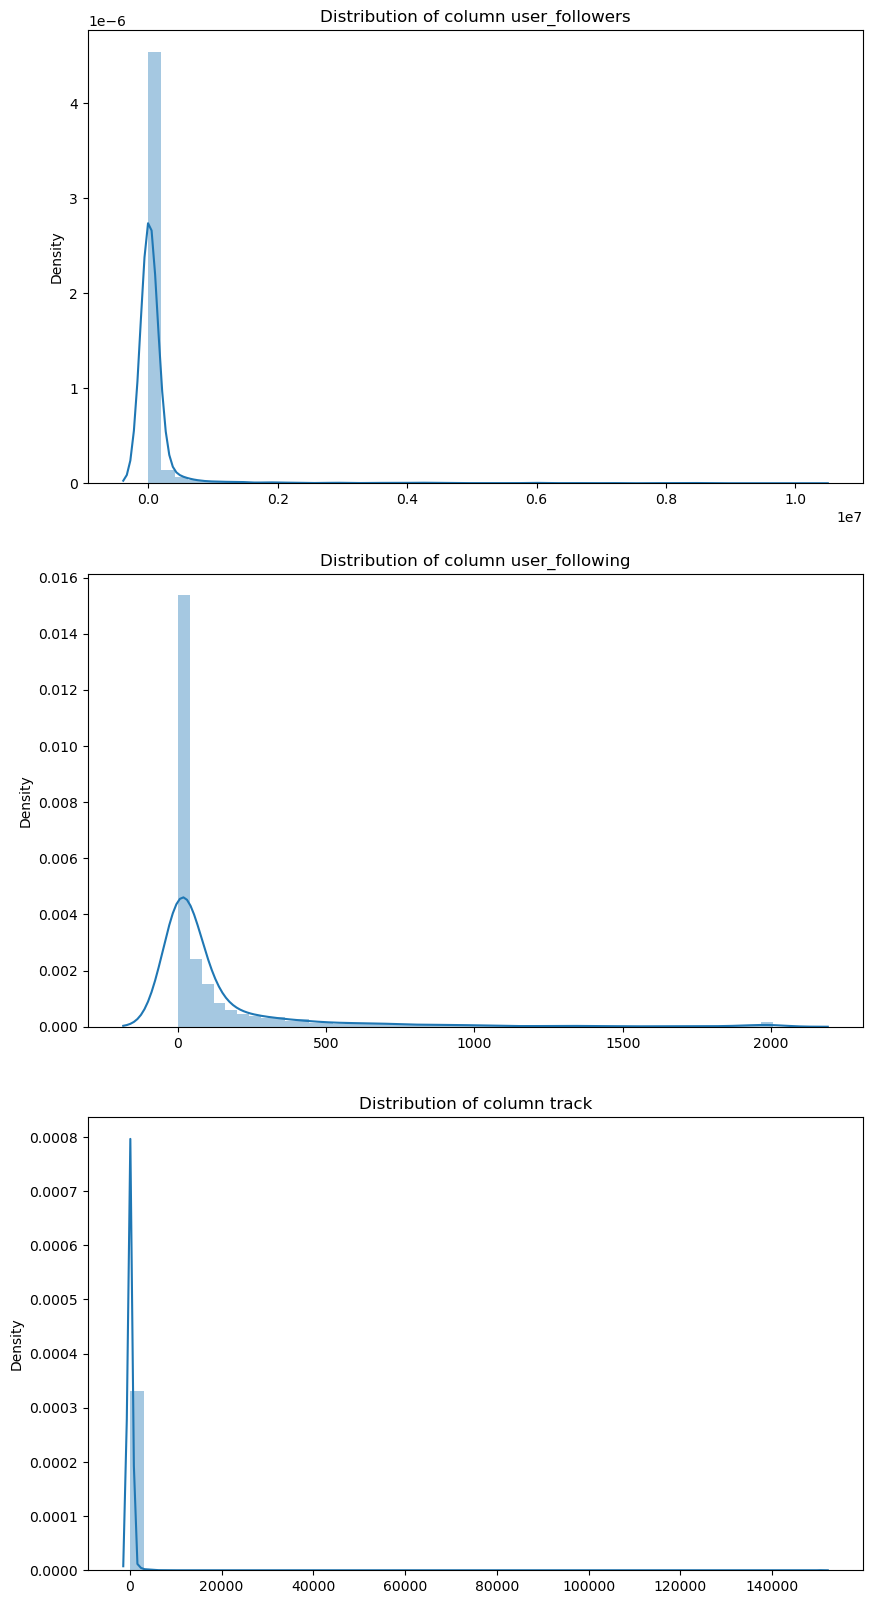

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
axes = axes.ravel()
numeric_cols = user_df.columns[5:8]
for col, ax in zip(numeric_cols, axes):
    sns.distplot(user_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

We can relize that all three features are right skewed **&rarr; Let transform it by log function**

In [13]:
for col in numeric_cols:
    user_df['log_'+ col] = np.log(user_df[col] + 0.0001)

Visualize again!

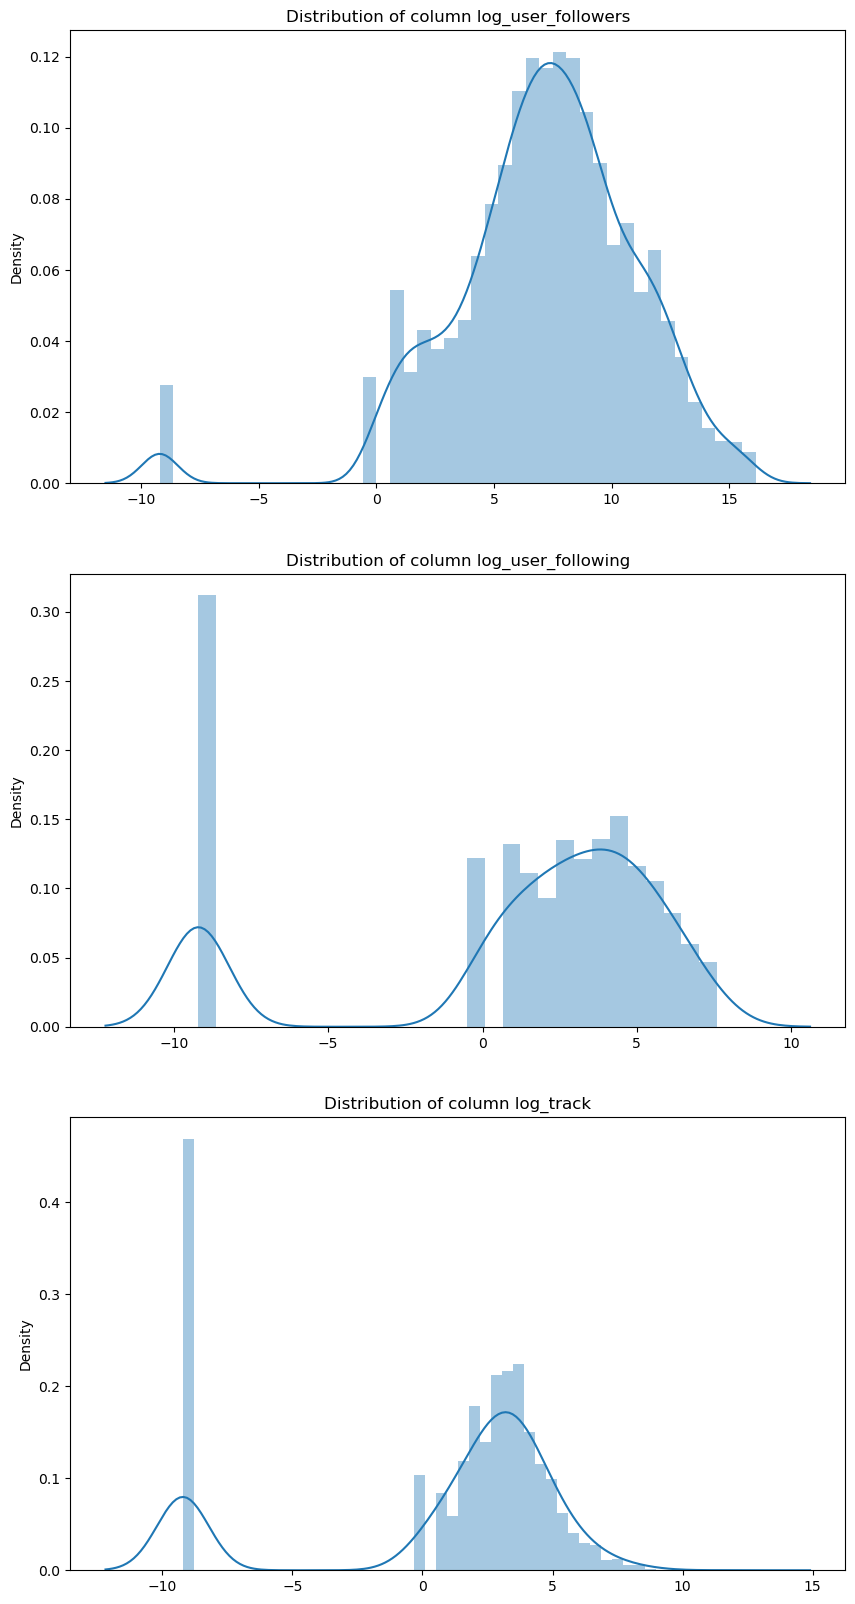

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
axes = axes.ravel()
log_numeric_cols = user_df.columns[8:11]
for col, ax in zip(log_numeric_cols, axes):
    sns.distplot(user_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

Now, we can see that all three plot look like normal distribution **&rarr; We can use normal distribution formula to drop outlier**

#### Outlier:

We can apply $3 \sigma$ rule in normal distribution

In normal distribution, suppose $\mu$ expectation and $\sigma$ standard deviatoin.
$3 \sigma$ rule for normal distribution speak:

* 68% data points lie in range $\mu \pm \sigma$
* 95% data points lie in range $\mu \pm 2\sigma$
* 99.7% data points lie in range $\mu \pm 3\sigma$

With a data point $x$, its Z-score can be calculated by:

$$
\frac{x - \mu}{\sigma}
$$

Data points have z score lie out of range $[-3, 3]$ can be seem as outlier. With a little bit math transformation, which is equivalent to the fact that the data points are outside the interval $[\mu - 3\sigma, \mu + 3\sigma]$ can be seem as outlier.

In [15]:
upper_limit = []
lower_limit = []
for col in log_numeric_cols:
    upper_limit.append(user_df[col].mean() + 3 * user_df[col].std())
    lower_limit.append(user_df[col].mean() - 3 * user_df[col].std())

condition = (user_df.log_user_followers > upper_limit[0]) | (user_df.log_user_followers < lower_limit[0]) |\
            (user_df.log_user_following > upper_limit[1]) | (user_df.log_user_following < lower_limit[1]) |\
            (user_df.log_track > upper_limit[2]) | (user_df.log_track < lower_limit[2])
user_df.loc[condition]

,username,user_url,confirm_owner,detail_name,country,user_followers,user_following,track,log_user_followers,log_user_following,log_track
user_id,,,,,,,,,,,
22,user248702449,https://www.soundcloud.com/user248702449,0,Missing,Missing,0,33,0,-9.2103,3.4965,-9.2103
28,Amira Hamd,https://www.soundcloud.com/amira-hamd-835794790,0,Amira Hamd,Missing,0,0,0,-9.2103,-9.2103,-9.2103
49,Night Angel,https://www.soundcloud.com/night-angel-5,0,Night Angel,Missing,0,14,0,-9.2103,2.6391,-9.2103
51,syeda tehseen,https://www.soundcloud.com/syeda-tehseen-7986593,0,syeda tehseen,Missing,0,0,0,-9.2103,-9.2103,-9.2103
53,User 375577961,https://www.soundcloud.com/user-375577961,0,Missing,Missing,0,0,0,-9.2103,-9.2103,-9.2103
65,Airaled Resendiz,https://www.soundcloud.com/airaled-resendiz,0,Airaled Resendiz,Missing,0,0,0,-9.2103,-9.2103,-9.2103
96,Ahmed Hashim,https://www.soundcloud.com/ahmed-hashim-261762856,0,Ahmed Hashim,Missing,0,0,0,-9.2103,-9.2103,-9.2103
99,Jordan2890,https://www.soundcloud.com/user-414171099,0,Missing,Missing,0,0,0,-9.2103,-9.2103,-9.2103
104,bast boy arshad abbasi,https://www.soundcloud.com/bast-boy-arshad-abbasi,0,bast boy arshad abbasi,Missing,0,0,0,-9.2103,-9.2103,-9.2103


Let drop it

In [16]:
print('Before drop: ', user_df.shape)
print('Number of outliers: ', user_df.loc[condition].shape)
user_df = user_df.loc[~condition]
print('After drop: ', user_df.shape)

Before drop:  (3777, 11)
Number of outliers:  (60, 11)
After drop:  (3717, 11)


Visualize again!

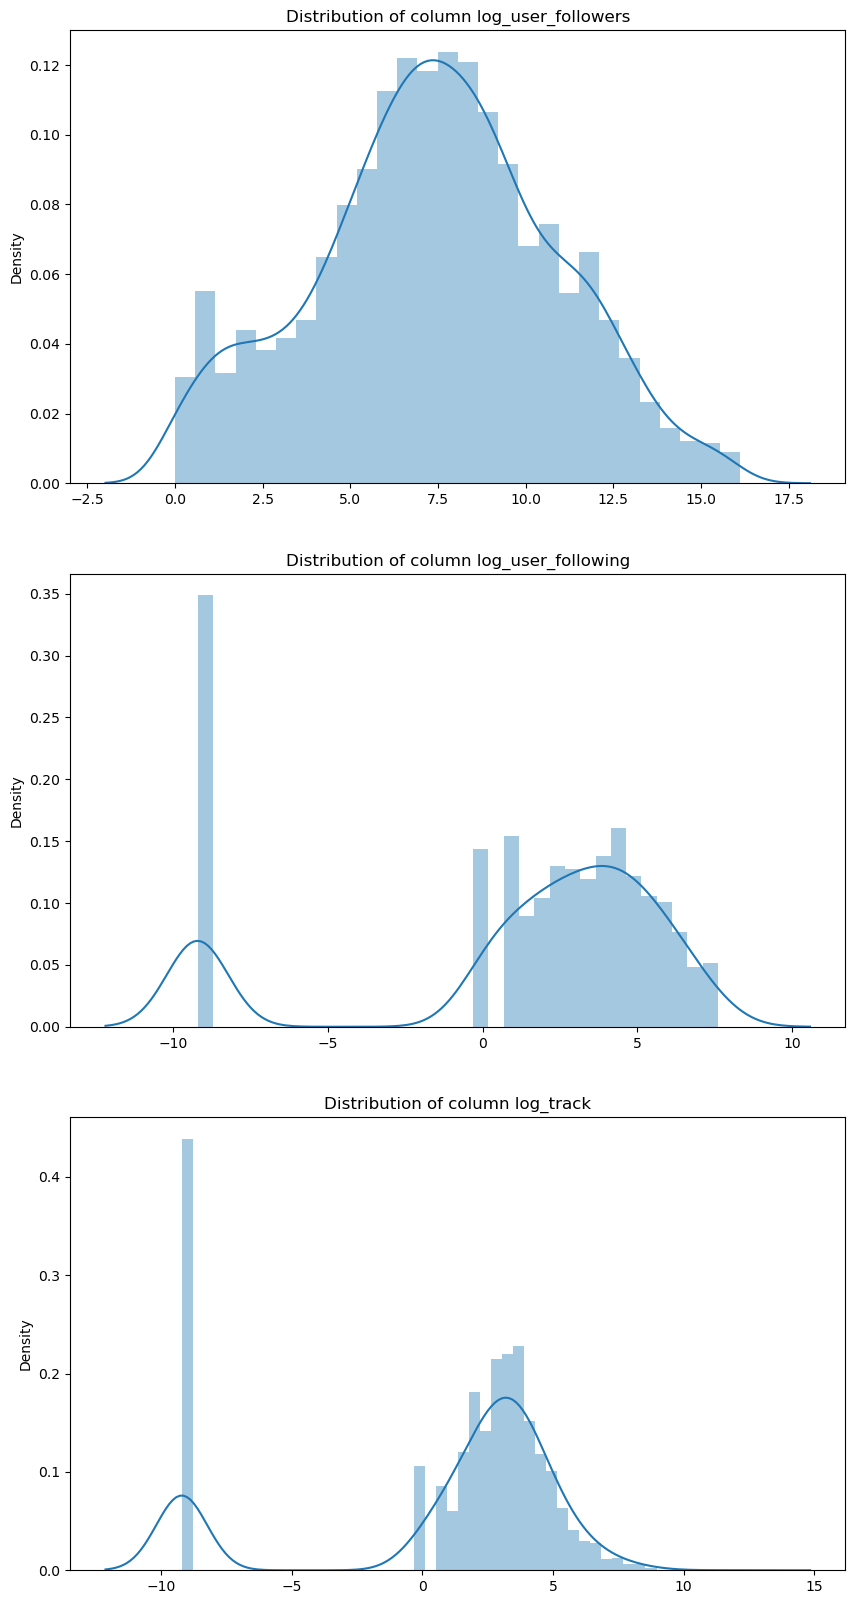

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
axes = axes.ravel()
log_numeric_cols = user_df.columns[8:11]
for col, ax in zip(log_numeric_cols, axes):
    sns.distplot(user_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

**&rarr; We can relize that there just *user_followers* drop all its outliers. This happens because the number of outlier of both *user_following* and *user_track* is too much!**

#### How creator's distribution on soundcloud?

In [18]:
user_df.confirm_owner.mean() * 100

23.944040893193435

In 100 soundcloud users, there are average 24 users is creators.

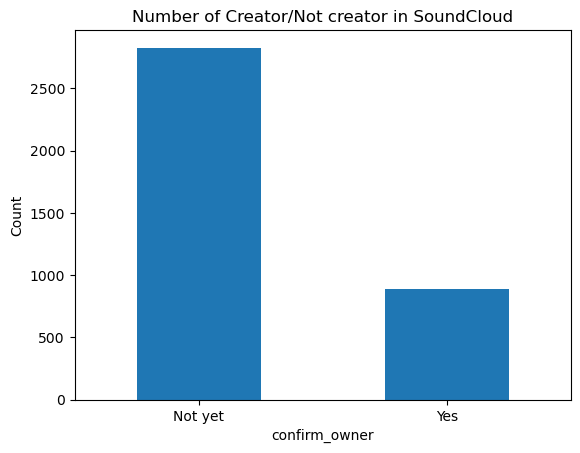

In [19]:
user_df.groupby('confirm_owner').size().plot(kind='bar')
plt.xticks([0, 1], ['Not yet', 'Yes'], rotation=0)
plt.ylabel('Count')
plt.title('Number of Creator/Not creator in SoundCloud')

plt.show()

#### Why do SoundCloud have too high ratio of artist although world ratio is far lower than?
The world artist ratio is over 0.025% ([2M](https://www.quora.com/How-many-artists-are-there-in-the-world) / [8B](https://www.google.com/search?q=world+population+2022&oq=world+population+2022&aqs=chrome..69i57j0i22i30l9.4865j1j7&sourceid=chrome&ie=UTF-8))

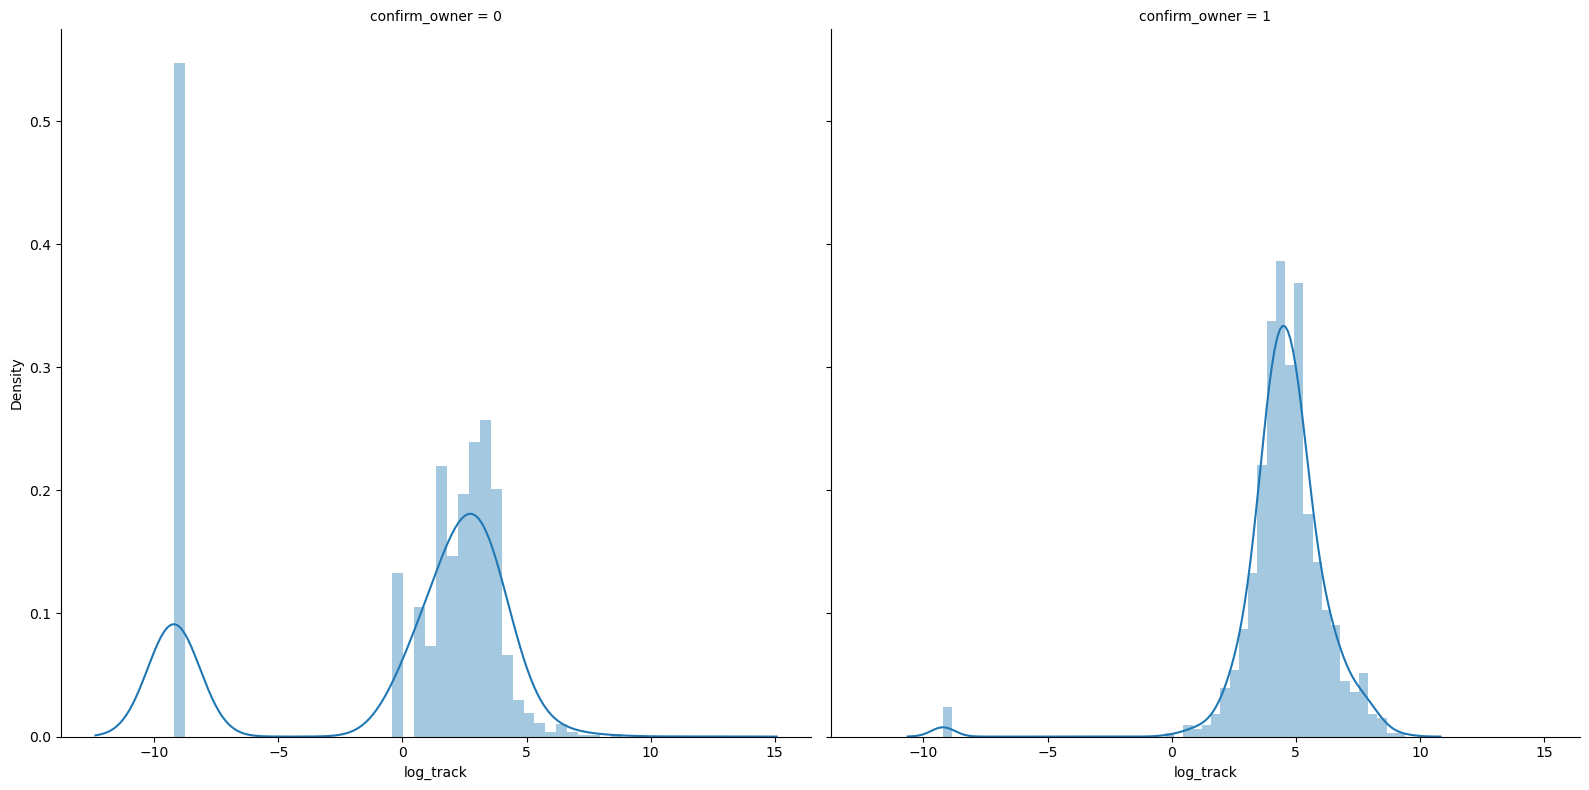

In [20]:
g = sns.FacetGrid(user_df, col='confirm_owner', height=8)
g.map(sns.distplot, 'log_track')

plt.show()

**&rarr; Artists have more tracks than normal users**

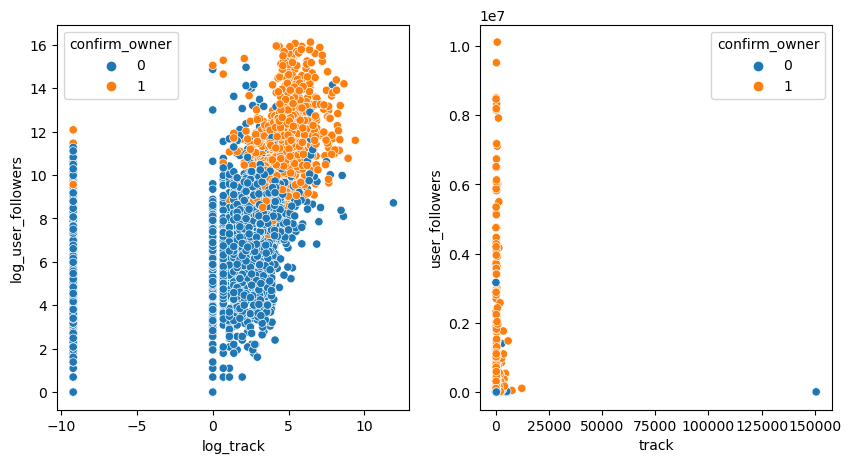

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=user_df.log_track, y=user_df.log_user_followers, hue=user_df.confirm_owner, ax=axes[0])
sns.scatterplot(x=user_df.track, y=user_df.user_followers, hue=user_df.confirm_owner, ax=axes[1])

plt.show()

**&rarr; We can relize that more tracks artist have, more followers. However, there are some artist have a little bit excepted artists go against it**

ANSWER: There is a fact that not like Spotify, Apple Music,... SoundCloud don't call their artist are artist, they call ***Creator***. Millions of creators use SoundCloud as a way to distribute music, demos and beats, with producers, singers and everything in-between collaborating on the platform. Many artists used the platform as a first step in their career. Therefore, we can see some creators have several hundreds tracks (it's too much with professional artist) and there are much followers or less followers (user can like their music style though number of tracks)

#### How are users distribution by country?

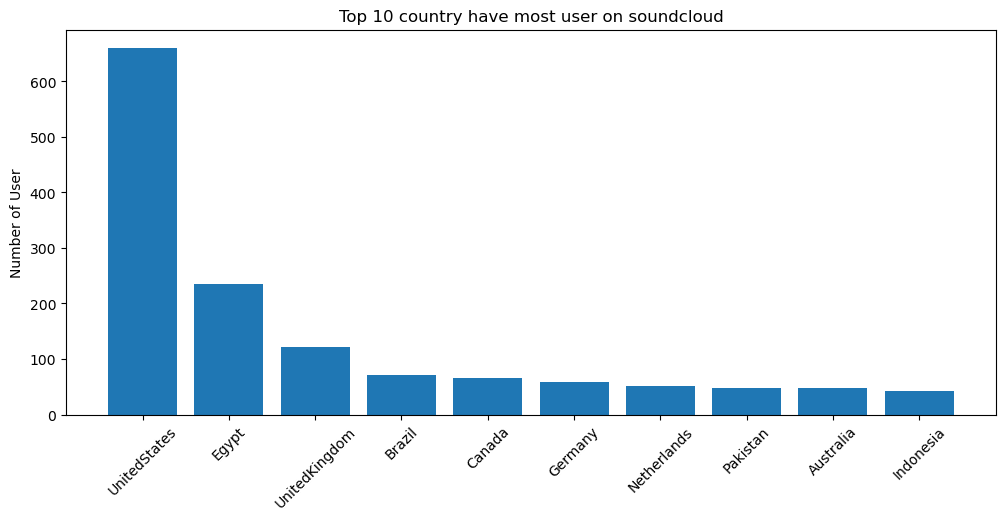

In [22]:
country = np.array(user_df['country']).astype('str')
country = country[country != 'Missing']

def updateCountry(s):
    s = s.replace(' ', '')
    ls = s.split(',')
    if(len(ls) != 1):
        return ls[-1]
    else:
        return ls[0]

US_state = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Chicago', 'Colorado', 'Connecticut', 'Delaware',
            'Florida', 'Georgia', 'Hawaii', 'Idaho', 'IllinoisIndiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 
            'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'MontanaNebraska', 
            'Nevada', 'NewHampshire', 'NewJersey', 'NewMexico', 'NewYork', 'NorthCarolina', 'NorthDakota', 'Ohio', 'Oklahoma', 
            'Oregon', 'Pennsylvania', 'RhodeIsland', 'SouthCarolina', 'SouthDakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 
            'WashingtonDC', 'WestVirginia', 'Wisconsin', 'Wyoming', 'LA']
for i in range(len(country)):
    country[i] = updateCountry(country[i])
    if country[i].lower() == 'london':
        country[i] = 'UnitedKingdom'
    elif country[i] in US_state:
        country[i] = 'UnitedState'

data, count = np.unique(country, return_counts=True)
count_sort_ind = np.argsort(-count)

data = data[count_sort_ind]
count = count[count_sort_ind]

x_bar = data[0:10]
y_bar = count[0:10]
plt.figure(figsize=(12,5)) 
plt.bar(x_bar, y_bar)
plt.ylabel("Number of User")
plt.xticks(rotation=45)
plt.title("Top 10 country have most user on soundcloud")
plt.show()

<Figure size 1200x500 with 0 Axes>

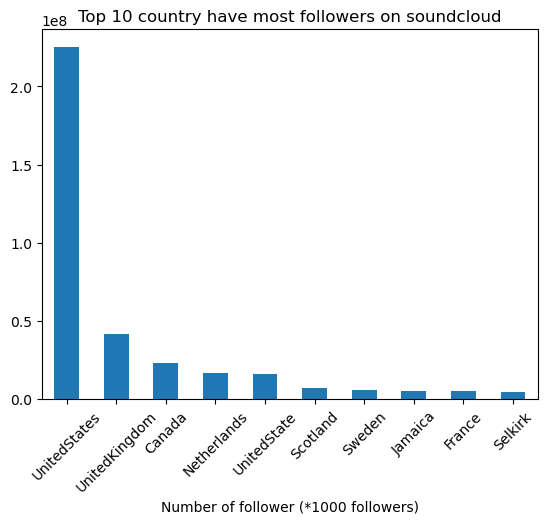

In [23]:
country_follower = user_df.loc[:, ['country', 'user_followers']].reset_index(drop=True)
country_follower['user_followers'].astype('int')
country_follower = country_follower[(country_follower.country != 'Missing')]
country_follower.country = country
country_follower = country_follower.groupby('country', as_index=False)['user_followers'].sum()\
                                        .sort_values('user_followers', ascending=False)


plt.figure(figsize=(12,5)) 
country_follower.head(10).set_index('country').plot(kind='bar')

plt.xlabel("Number of follower (*1000 followers)")
plt.xticks(rotation=45)
plt.title("Top 10 country have most followers on soundcloud")
plt.legend().remove()
plt.show()

<Figure size 1200x500 with 0 Axes>

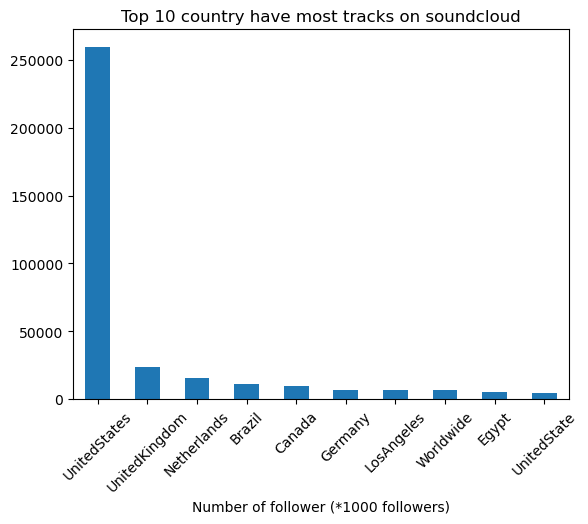

In [24]:
country_track = user_df.loc[:, ['country', 'track']].reset_index(drop=True)
country_track['track'].astype('int')
country_track = country_track[(country_track.country != 'Missing')]
country_track.country = country
country_track = country_track.groupby('country', as_index=False)['track'].sum()\
                                        .sort_values('track', ascending=False)


plt.figure(figsize=(12,5)) 
country_track.head(10).set_index('country').plot(kind='bar')

plt.xlabel("Number of follower (*1000 followers)")
plt.xticks(rotation=45)
plt.title("Top 10 country have most tracks on soundcloud")
plt.legend().remove()
plt.show()

- Almost users follow users from US, UK, ...
- US also is country which have most users.  
**&rarr; Current trends in music include the UK, America and so on. The number of users in these countries is high because these are developed countries, with early access to technology. And since it had many colonies in time of war, their culture also affected the occupied countries.**

#### How are *confirm_owner*, *user_followers*, *user_followering*, *track* affect to each other?

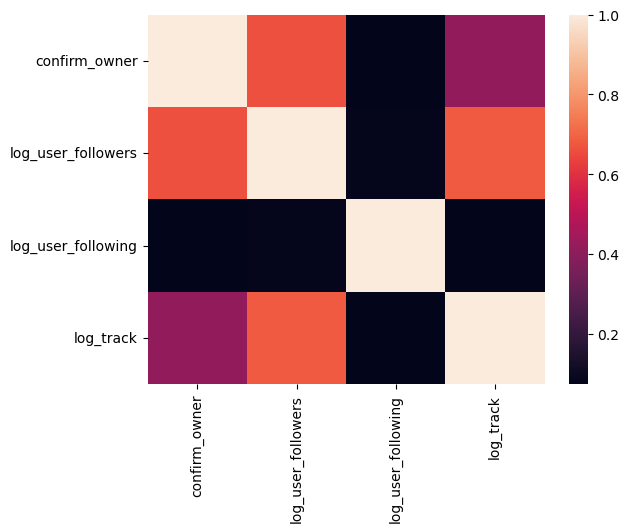

In [25]:
sns.heatmap(user_df[['confirm_owner', 'log_user_followers', 'log_user_following', 'log_track']].corr())
plt.show()

From heatmap above and far above scatterplot, we conclude:
- There are no strong correlation between *user_following* and *track*, *user_following*  and *user_follower*  
- It is mainly those with a small number of tracks who have a small number of tracks. There are a few users whose tracks are not too many (< 100 tracks) but highly followed, possibly popular artists' accounts that promote their songs themselves.

## 2.2. Playlist:

### 2.2.1. EDA:

In [126]:
playlist_df = pd.read_csv('./SoundcloudData/playlist.csv', encoding='utf-8')
playlist_df.head()

,playlist_id,playlist_name,playlist_url,owner_id,username,playlist_time,playlist_tag,like,repost,size,tracks
0,0,musicas relaxantes,https://www.soundcloud.com/eliana-cogine/sets/...,0,lihcogine,2015-04-09T00:21:34.000Z,NaN,215,15,44,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,Midnight Lofi,https://www.soundcloud.com/butterxly/sets/midn...,1,lonesomejupiter,2018-09-19T15:36:33.000Z,Lo-fi,329,23,36,"[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5..."
2,2,Morning Chillout,https://www.soundcloud.com/mightyj-1/sets/morn...,2,Mighty,2020-06-30T15:25:37.000Z,chill,161,7704,100,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9..."
3,3,meditation,https://www.soundcloud.com/rehan-khan-55/sets/...,3,Rehan Khan 55,2017-01-04T18:20:57.000Z,NaN,154,9195,12,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ..."
4,4,Music,https://www.soundcloud.com/jig-saw19/sets/music,4,jcool19_,2014-06-05T02:12:23.000Z,NaN,18,3,10,"[192, 193, 194, 195, 196, 197, 198, 199, 200, ..."


Similarly to *user_df*, we should set *playlist_id* as index

In [37]:
playlist_df = playlist_df.set_index('playlist_id')
playlist_df.head()

,playlist_name,playlist_url,owner_id,username,playlist_time,playlist_tag,like,repost,size,tracks
playlist_id,,,,,,,,,,
0,musicas relaxantes,https://www.soundcloud.com/eliana-cogine/sets/...,0,lihcogine,2015-04-09T00:21:34.000Z,NaN,215,15,44,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,Midnight Lofi,https://www.soundcloud.com/butterxly/sets/midn...,1,lonesomejupiter,2018-09-19T15:36:33.000Z,Lo-fi,329,23,36,"[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5..."
2,Morning Chillout,https://www.soundcloud.com/mightyj-1/sets/morn...,2,Mighty,2020-06-30T15:25:37.000Z,chill,161,7704,100,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9..."
3,meditation,https://www.soundcloud.com/rehan-khan-55/sets/...,3,Rehan Khan 55,2017-01-04T18:20:57.000Z,NaN,154,9195,12,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ..."
4,Music,https://www.soundcloud.com/jig-saw19/sets/music,4,jcool19_,2014-06-05T02:12:23.000Z,NaN,18,3,10,"[192, 193, 194, 195, 196, 197, 198, 199, 200, ..."


#### How many rows and column in dataset?

In [38]:
n_rows, n_cols = playlist_df.shape
print(f'Playlist dataframe shape: {n_rows} rows and {n_cols} columns')

Playlist dataframe shape: 1164 rows and 10 columns


#### Is data duplicated?

In [39]:
any(playlist_df.duplicated())

False

#### What is the meaning of each columns?

**Mean of each column:**
- playlist_name: playlist name
- playlist_url: url direct to playlist page
- owner_id: user id who create playlist
- username: username of user who create playlist
- playlist_time: time on which playlist was created
- playlist_tag: main kind of playlist
- like: number of like
- repost: number of repost
- size: number of track in playlist
- tracks: list of tracks id in playlist

#### What is the datatype of each column? Are there any columns with datatypes that are not suitable for further processing?

In [40]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164 entries, 0 to 1163
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   playlist_name  1164 non-null   object
 1   playlist_url   1164 non-null   object
 2   owner_id       1164 non-null   int64 
 3   username       1164 non-null   object
 4   playlist_time  1164 non-null   object
 5   playlist_tag   298 non-null    object
 6   like           1164 non-null   int64 
 7   repost         1164 non-null   int64 
 8   size           1164 non-null   int64 
 9   tracks         1164 non-null   object
dtypes: int64(4), object(6)
memory usage: 100.0+ KB


**Note:**
- *playlist_time* should be converted to datetime type
- *playlist_tag* should be converted to string

#### Are there any columns have missing value?

In [41]:
miss_num = playlist_df.isnull().sum(axis=0).sort_values(ascending=False)
miss_percent = miss_num / n_rows * 100

pd.DataFrame({'Count':miss_num, '%':miss_percent})

,Count,%
playlist_tag,866,74.3986
playlist_name,0,0.0000
playlist_url,0,0.0000
owner_id,0,0.0000
username,0,0.0000
playlist_time,0,0.0000
like,0,0.0000
repost,0,0.0000
size,0,0.0000
tracks,0,0.0000


Because of *country* and *playlist_tag* dtypes, we will replace missing value with string 'Missing'

#### What is the distribution of data?

In [42]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
playlist_df.describe()

,owner_id,like,repost,size
count,1164.0000,1164.0000,1164.0000,1164.0000
mean,444.8385,776.8084,624.7405,23.2629
std,284.2235,1928.1028,1469.7264,60.6405
min,0.0000,0.0000,0.0000,0.0000
25%,184.7500,4.0000,0.0000,3.0000
50%,425.5000,21.0000,8.0000,5.0000
75%,689.2500,190.2500,402.2500,11.0000
max,951.0000,9953.0000,9768.0000,442.0000


In [43]:
playlist_df.describe(include='O')

,playlist_name,playlist_url,username,playlist_time,playlist_tag,tracks
count,1164,1164,1164,1164,298,1164
unique,1057,1164,948,1159,133,1017
top,lil richoe,https://www.soundcloud.com/eliana-cogine/sets/...,SoundCloud,2020-10-10T03:23:12.000Z,Electronic,[]
freq,25,1,31,3,28,141


---

### 2.2.2. Preprocessing:

In [44]:
playlist_df.playlist_tag = playlist_df.playlist_tag.fillna('Missing')
playlist_df.playlist_time = pd.to_datetime(playlist_df.playlist_time)

playlist_df.head()

,playlist_name,playlist_url,owner_id,username,playlist_time,playlist_tag,like,repost,size,tracks
playlist_id,,,,,,,,,,
0,musicas relaxantes,https://www.soundcloud.com/eliana-cogine/sets/...,0,lihcogine,2015-04-09 00:21:34+00:00,Missing,215,15,44,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,Midnight Lofi,https://www.soundcloud.com/butterxly/sets/midn...,1,lonesomejupiter,2018-09-19 15:36:33+00:00,Lo-fi,329,23,36,"[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5..."
2,Morning Chillout,https://www.soundcloud.com/mightyj-1/sets/morn...,2,Mighty,2020-06-30 15:25:37+00:00,chill,161,7704,100,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9..."
3,meditation,https://www.soundcloud.com/rehan-khan-55/sets/...,3,Rehan Khan 55,2017-01-04 18:20:57+00:00,Missing,154,9195,12,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ..."
4,Music,https://www.soundcloud.com/jig-saw19/sets/music,4,jcool19_,2014-06-05 02:12:23+00:00,Missing,18,3,10,"[192, 193, 194, 195, 196, 197, 198, 199, 200, ..."


In [45]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164 entries, 0 to 1163
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   playlist_name  1164 non-null   object             
 1   playlist_url   1164 non-null   object             
 2   owner_id       1164 non-null   int64              
 3   username       1164 non-null   object             
 4   playlist_time  1164 non-null   datetime64[ns, UTC]
 5   playlist_tag   1164 non-null   object             
 6   like           1164 non-null   int64              
 7   repost         1164 non-null   int64              
 8   size           1164 non-null   int64              
 9   tracks         1164 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 100.0+ KB


---

### 2.2.3. EDA (cont):

#### Let's take a look at the distribution plot of numeric features

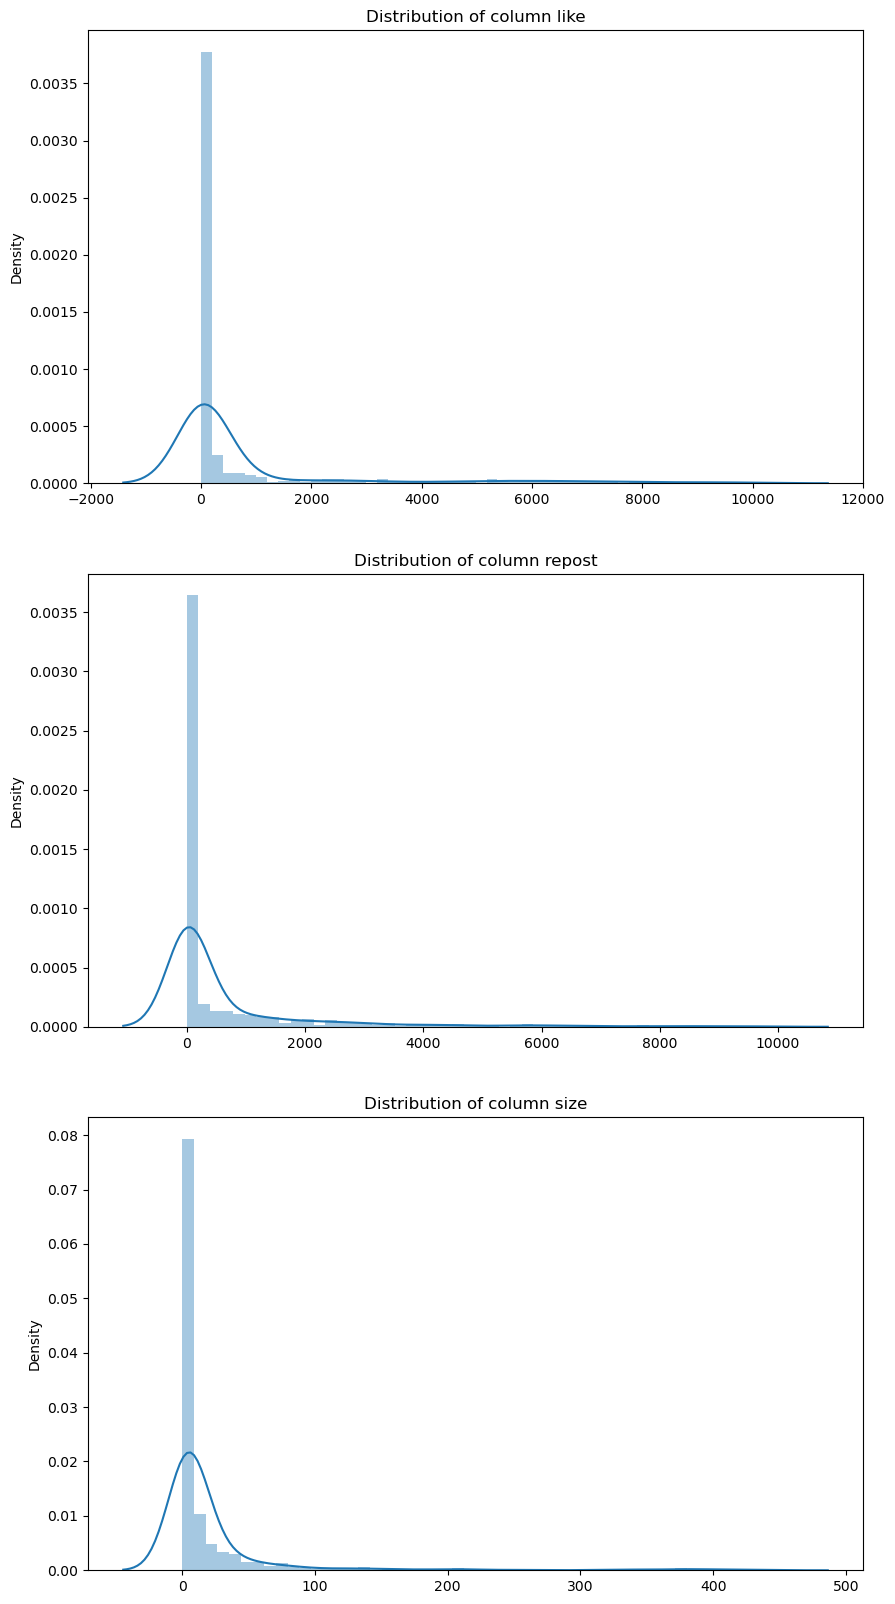

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
axes = axes.ravel()
numeric_cols = playlist_df.columns[6:9]
for col, ax in zip(numeric_cols, axes):
    sns.distplot(playlist_df[col].values, ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

We can relize that all three features are right skewed **&rarr; Let transform it by log function**

In [47]:
for col in numeric_cols:
    playlist_df['log_'+ col] = np.log1p(playlist_df[col])

Visualize again!

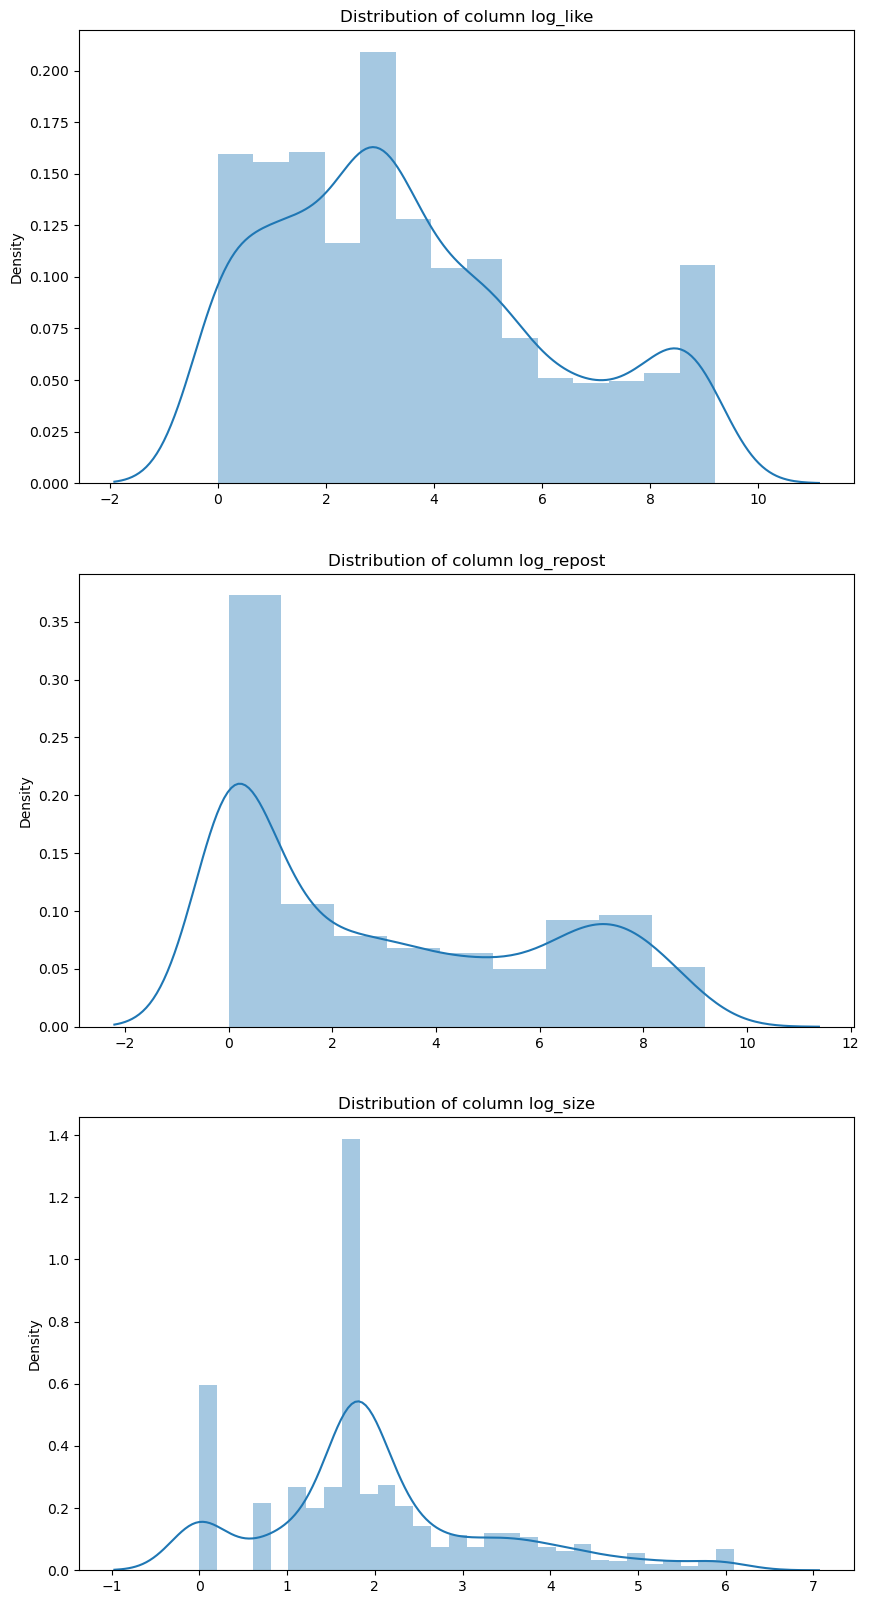

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
axes = axes.ravel()
log_numeric_cols = playlist_df.columns[10:13]
for col, ax in zip(log_numeric_cols, axes):
    sns.distplot(playlist_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

We can see that there is no distribution plot look like normal distribution **&rarr; We can drop outlier by [clipping to maximun and minimum of box plot](https://machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html)**

#### Outlier:

In [55]:
upper_limit = []
lower_limit = []
for col in numeric_cols:
    q1 = playlist_df[col].quantile(0.25)
    q3 = playlist_df[col].quantile(0.75)
    iqr = q3 - q1

    upper_limit.append(q3 + 3 * iqr)
    lower_limit.append(q1 - 3 * iqr)

condition = (playlist_df.like <= upper_limit[0]) & (playlist_df.like >= lower_limit[0]) &\
            (playlist_df.repost <= upper_limit[1]) & (playlist_df.repost >= lower_limit[1]) &\
            (playlist_df.size <= upper_limit[2]) & (playlist_df.size >= lower_limit[2])

condition.sum()

0

We can relize that all playlist dataframe are outlier! &rarr; So we don't drop anything!

#### What types of playlists are popular?

In [94]:
playlist_type = playlist_df.loc[:, ['playlist_tag', 'like', 'repost']]
playlist_type = playlist_type[~(playlist_type.playlist_tag == "Missing")]

Lofi = ['Lo-fi', 'chill', 'lofi-jazzflow', 'Learning', 'Chillout', 'education', 'Chill', 'Radio', 'Audiobooks', 'Podcast', 'coffee', 'Sleep', 'Lo-Fi, Chill, Study', 'Chillstep', 'Education', 'audiobook', 'Lofi Hip Hop', 'Lofi', 'lofi hip hop', 'Lo-fi HipHop', 'Audiobook']
Motivation = ['WorkOut', 'Morning', 'Motivation', 'Hardstyle Gym', 'Fitness', 'Workout']
Undergroud = ['Hip Hop', 'Hip-hop & Rap', 'hip hop', 'Underground']
Dance_Electronic = ['Dance & EDM', 'Electronic', 'electronic dance music', 'electronic', 'electro', 'Dance', 'Party', 'Gaming', 'Sports', 'Electro', 'dance', 'electro house', 'Edm']
Instrument = ['slow piano', 'beauty', 'Instrumental Music']
Blue = ['R&B', 'Rock', 'R&B & Soul', 'Soul']
Classical = ['Classical', 'Jazz', 'Drum & Bass', 'Drum & Bass #Neurofunk # Liquid']
Popular = ['Country', 'Pop', 'Indie', 'pop', 'vibes', 'indie', 'K-Pop', 'korean', 'Kpop', 'Comedy', 'LOVE', 'Indie Folk', 'Acoustic', 'Folk & Singer-Songwriter', 'sad']
Other = list(set(playlist_type.playlist_tag.unique()) - set(Lofi + Motivation + Undergroud + Dance_Electronic + Intrusment + Blue + Classical + Popular))

playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Lofi, 'Lofi')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Motivation, 'Motivation')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Undergroud, 'Underground')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Dance_Electronic, 'Dance & Electronic')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Instrument, 'Intrusment')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Blue, 'Blue')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Classical, 'Classical')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Popular, 'Popular')
playlist_type.playlist_tag = playlist_type.playlist_tag.replace(Other, 'Other')

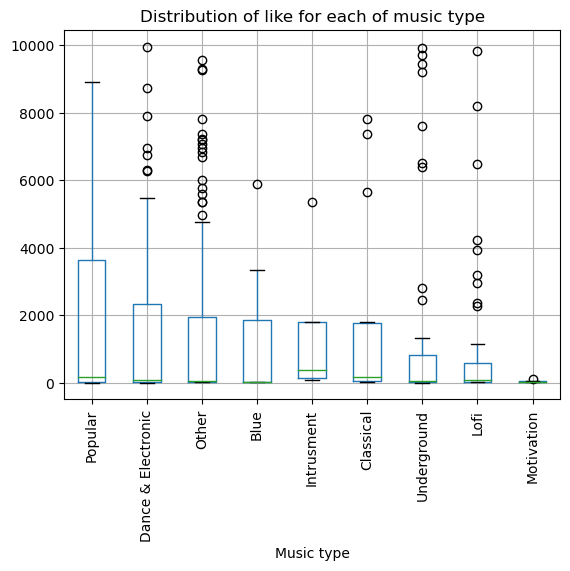

In [95]:
grouped = playlist_type.groupby('playlist_tag')
df2 = pd.DataFrame({col:vals['like'] for col,vals in grouped})

mea = df2.quantile(0.75)
mea.sort_values(ascending=False, inplace=True)
df2 = df2[mea.index]
df2.boxplot()

plt.xticks(rotation=90)
plt.xlabel('Music type')
plt.title('Distribution of like for each of music type')
plt.show()

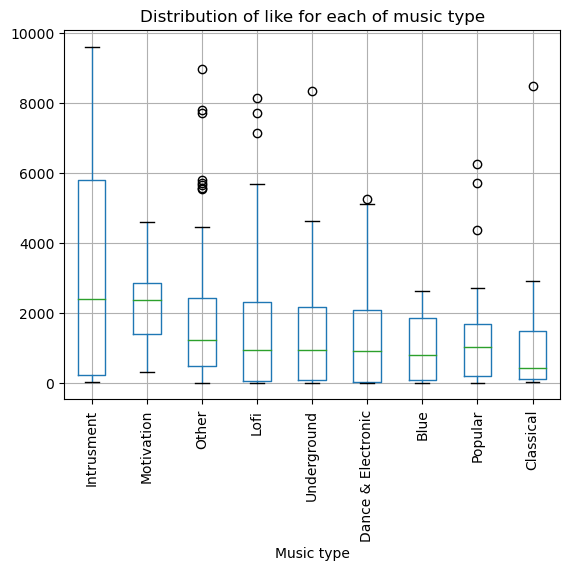

In [96]:
grouped = playlist_type.groupby('playlist_tag')
df2 = pd.DataFrame({col:vals['repost'] for col,vals in grouped})

mea = df2.quantile(0.75)
mea.sort_values(ascending=False, inplace=True)
df2 = df2[mea.index]
df2.boxplot()

plt.xticks(rotation=90)
plt.xlabel('Music type')
plt.title('Distribution of like for each of music type')
plt.show()

- Playlists whose type is *Popular*, *Dance & Electronic*,... have most like because of catchy melody, popular and amazing impression.  
- However, *Instrument* or *Lofi* type have the most repost because of this gentle melody, tunable so it is repost to later listerning for reducing stress, chilling, relaxing and so on.

#### How does the playlists change over time?

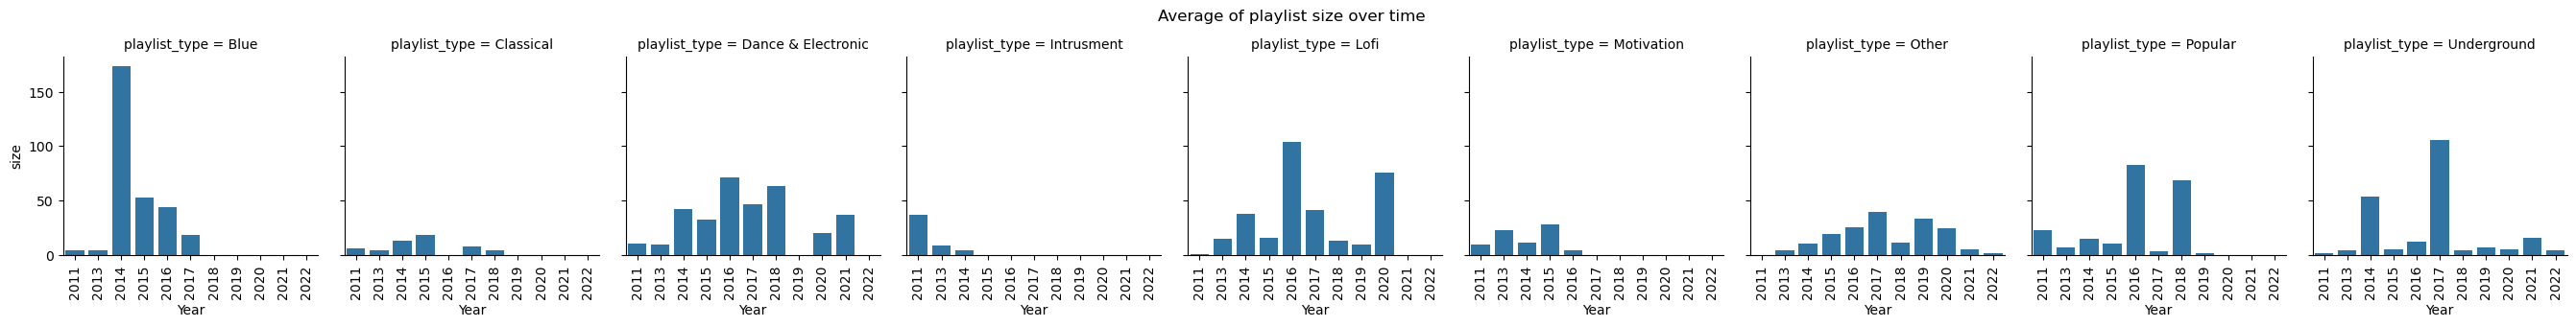

In [115]:
playlist_df['Year'] = playlist_df.playlist_time.dt.year
playlist_df['playlist_type'] = playlist_type.playlist_tag
pll_type_year_size = playlist_df.groupby(['playlist_type', 'Year'], as_index=False)['size'].mean()

g = sns.FacetGrid(pll_type_year_size, col='playlist_type')
g.map(sns.barplot, 'Year', 'size')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
g.fig.suptitle('Average of playlist size over time', y=1.05)

plt.show()

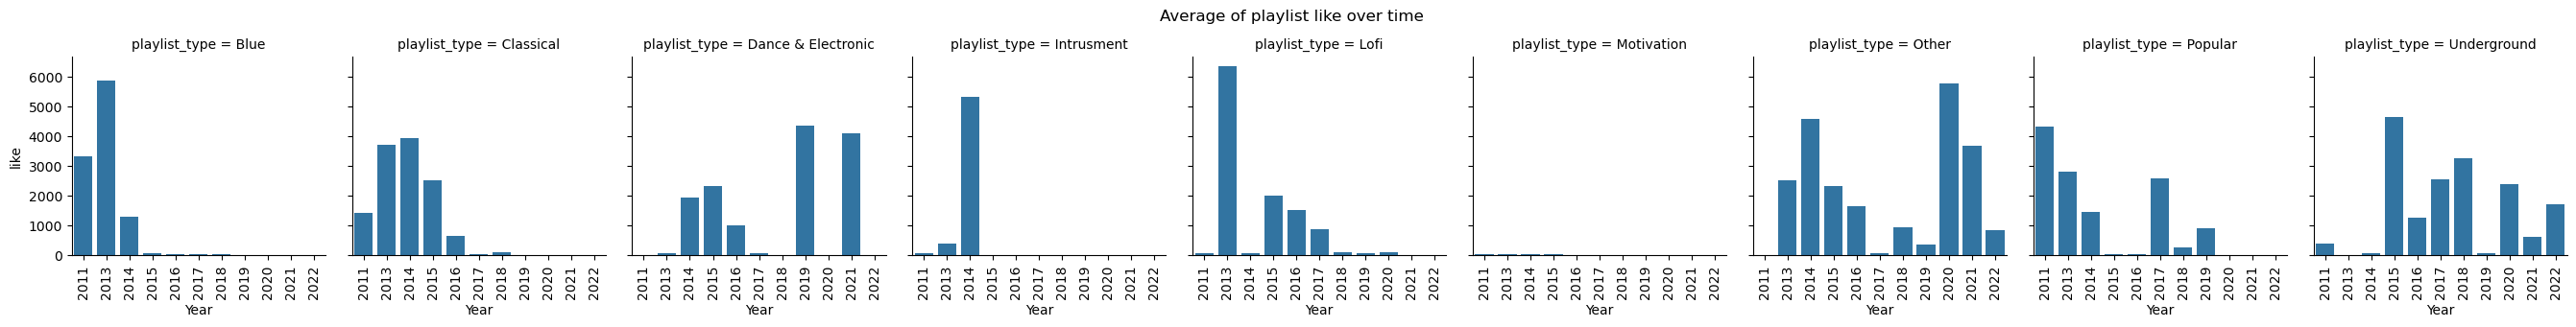

In [116]:
playlist_df['Year'] = playlist_df.playlist_time.dt.year
playlist_df['playlist_type'] = playlist_type.playlist_tag
pll_type_year_size = playlist_df.groupby(['playlist_type', 'Year'], as_index=False)['like'].mean()

g = sns.FacetGrid(pll_type_year_size, col='playlist_type')
g.map(sns.barplot, 'Year', 'like')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
g.fig.suptitle('Average of playlist like over time', y=1.05)

plt.show()

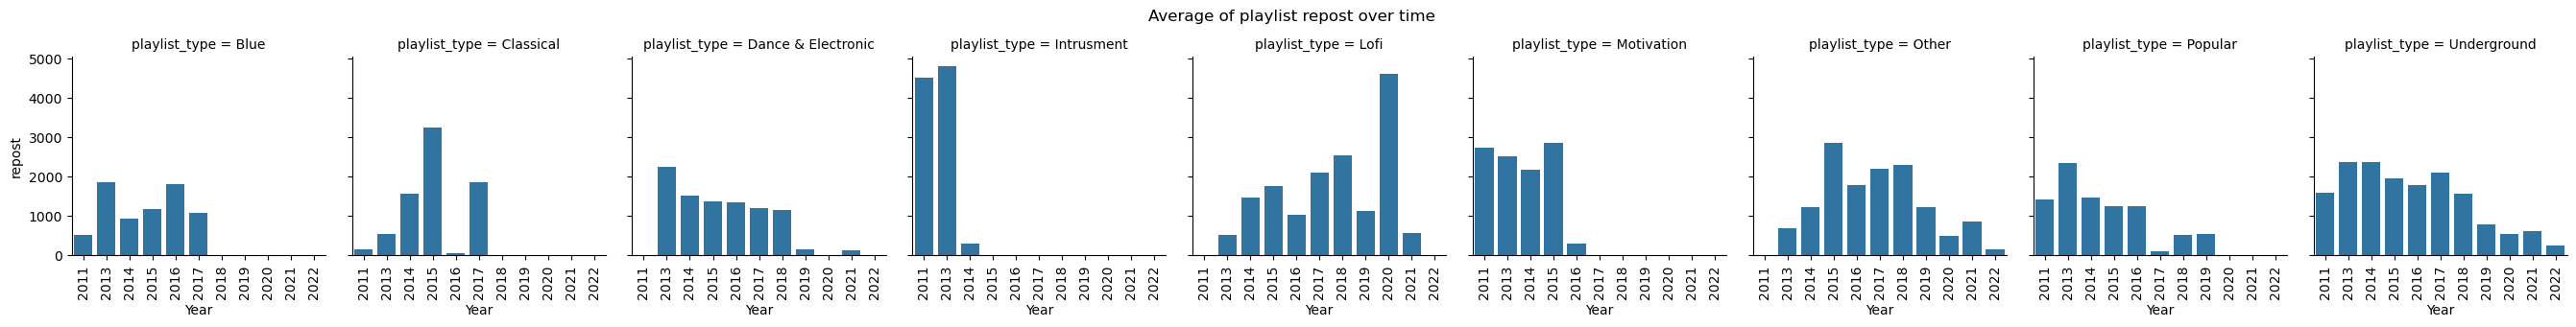

In [117]:
playlist_df['Year'] = playlist_df.playlist_time.dt.year
playlist_df['playlist_type'] = playlist_type.playlist_tag
pll_type_year_size = playlist_df.groupby(['playlist_type', 'Year'], as_index=False)['repost'].mean()

g = sns.FacetGrid(pll_type_year_size, col='playlist_type')
g.map(sns.barplot, 'Year', 'repost')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
g.fig.suptitle('Average of playlist repost over time', y=1.05)

plt.show()

From 3 plots above, we can conclude:
- The common size, like, repost of all type playlist downtrend recently.  
- *Dance*, *Lofi*, *Underground* are the most popular recently.
- There are the fact that *Instrument* type had most repost in the last. Nowaday, *Lofi* and *Underground* have been reposted mostly recently.

#### How do *size*, *like*, *repost* affect to each other?

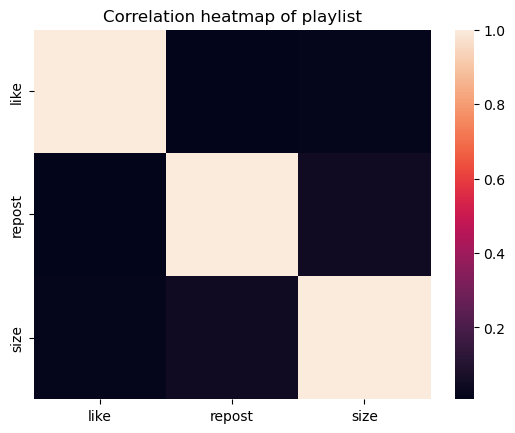

In [119]:
sns.heatmap(playlist_df[['like', 'repost', 'size']].corr())

plt.title("Correlation heatmap of playlist")
plt.show()

We can relize that all three variable have weak correlated to others!

## 2.3. Tracks:

### 2.3.1. EDA:

In [3]:
track_df = pd.read_csv('./SoundcloudData/track.csv', encoding='utf-8')
track_df.head(5)

,track_id,track_name,url,user_id,username,datetime,track_tag,track_play,track_like,track_comment,track_repost
0,624,bopp,https://www.soundcloud.com/e66s/bopp,952,E66S,2016-03-16T03:35:22.000Z,bump,4652488,40222,333,1767
1,22908,Vincent McMorrow - Wicked Game (David Keller R...,https://www.soundcloud.com/mono-music/vincent-...,954,David Keller,2012-12-28T19:27:30.000Z,Deep House,546736,9375,198,1079
2,3552,Louis Armstrong & Ella Fitzgerald - Love Is He...,https://www.soundcloud.com/bruno-takano/louis-...,953,Bruno Takano,2012-11-21T02:16:17.000Z,Jazz,3398333,57382,428,4943
3,19,Chivalry Is Dead,https://www.soundcloud.com/trevorwesley/chival...,956,Trevor Wesley,2015-02-11T06:17:30.000Z,pop,9733744,130182,973,15685
4,6309,are you there?,https://www.soundcloud.com/xstaytunedx/are-you...,955,Stay Tuned,2018-07-16T14:14:30.000Z,NaN,716056,8920,244,232


Similarly to *user_df*, *playlist_df*, we should set *track_id* as index

In [4]:
track_df = track_df.set_index('track_id')
track_df.head()

,track_name,url,user_id,username,datetime,track_tag,track_play,track_like,track_comment,track_repost
track_id,,,,,,,,,,
624,bopp,https://www.soundcloud.com/e66s/bopp,952,E66S,2016-03-16T03:35:22.000Z,bump,4652488,40222,333,1767
22908,Vincent McMorrow - Wicked Game (David Keller R...,https://www.soundcloud.com/mono-music/vincent-...,954,David Keller,2012-12-28T19:27:30.000Z,Deep House,546736,9375,198,1079
3552,Louis Armstrong & Ella Fitzgerald - Love Is He...,https://www.soundcloud.com/bruno-takano/louis-...,953,Bruno Takano,2012-11-21T02:16:17.000Z,Jazz,3398333,57382,428,4943
19,Chivalry Is Dead,https://www.soundcloud.com/trevorwesley/chival...,956,Trevor Wesley,2015-02-11T06:17:30.000Z,pop,9733744,130182,973,15685
6309,are you there?,https://www.soundcloud.com/xstaytunedx/are-you...,955,Stay Tuned,2018-07-16T14:14:30.000Z,NaN,716056,8920,244,232


#### How many rows and column in dataset?

In [5]:
n_rows, n_cols = track_df.shape
print(f'Playlist dataframe shape: {n_rows} rows and {n_cols} columns')

Playlist dataframe shape: 4183 rows and 10 columns


#### Is data duplicated?

In [8]:
any(track_df.duplicated())

False

#### What is the meaning of each columns?

**Mean of each column:**
- track_name: name of track
- url: url direct to track page
- datetime: time on which track was created
- track_tag: genre
- track_play: number of play time
- track_like: number of like
- track_repost: number of repost

#### What is the datatype of each column? Are there any columns with datatypes that are not suitable for further processing?

In [9]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4183 entries, 624 to 10318
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_name     4183 non-null   object
 1   url            4183 non-null   object
 2   user_id        4183 non-null   int64 
 3   username       4183 non-null   object
 4   datetime       4183 non-null   object
 5   track_tag      3254 non-null   object
 6   track_play     4183 non-null   int64 
 7   track_like     4183 non-null   int64 
 8   track_comment  4183 non-null   int64 
 9   track_repost   4183 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 359.5+ KB


**Note:**
- *playlist_time* should be converted to datetime type

#### Are there any columns have missing value?

In [10]:
miss_num = track_df.isnull().sum(axis=0).sort_values(ascending=False)
miss_percent = miss_num / n_rows * 100

pd.DataFrame({'Count':miss_num, '%':miss_percent})

,Count,%
track_tag,929,22.208941
track_name,0,0.000000
url,0,0.000000
user_id,0,0.000000
username,0,0.000000
datetime,0,0.000000
track_play,0,0.000000
track_like,0,0.000000
track_comment,0,0.000000
track_repost,0,0.000000


Because of *country* and *playlist_tag* dtypes, we will replace missing value with string 'Missing'

#### What is the distribution of data?

In [11]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
track_df.describe()

,user_id,track_play,track_like,track_comment,track_repost
count,4183.0000,4183.0000,4183.0000,4183.0000,4183.0000
mean,1984.8661,7598170.3696,111324.6070,1878.5128,6663.0241
std,959.3117,20845812.4215,265860.8556,10222.7688,18600.7763
min,12.0000,0.0000,0.0000,0.0000,0.0000
25%,1232.5000,155821.0000,2119.0000,25.0000,116.5000
50%,1895.0000,972463.0000,14752.0000,162.0000,740.0000
75%,2770.5000,4972779.0000,78499.5000,791.5000,4110.5000
max,3777.0000,326529637.0000,3165294.0000,349574.0000,256523.0000


In [12]:
track_df.describe(include='O')

,track_name,url,username,datetime,track_tag
count,4183,4183,4183,4183,3254
unique,4178,4183,2906,4121,1319
top,𝙃𝘼𝙍𝘿𝙎𝙏𝙔𝙇𝙀,https://www.soundcloud.com/e66s/bopp,SoundCloud,2013-05-01T03:18:18.000Z,Hip-hop & Rap
freq,3,1,57,6,328


---

### 2.3.2. Preprocessing:

In [13]:
track_df.datetime = pd.to_datetime(track_df.datetime)
track_df.head()

,track_name,url,user_id,username,datetime,track_tag,track_play,track_like,track_comment,track_repost
track_id,,,,,,,,,,
624,bopp,https://www.soundcloud.com/e66s/bopp,952,E66S,2016-03-16 03:35:22+00:00,bump,4652488,40222,333,1767
22908,Vincent McMorrow - Wicked Game (David Keller R...,https://www.soundcloud.com/mono-music/vincent-...,954,David Keller,2012-12-28 19:27:30+00:00,Deep House,546736,9375,198,1079
3552,Louis Armstrong & Ella Fitzgerald - Love Is He...,https://www.soundcloud.com/bruno-takano/louis-...,953,Bruno Takano,2012-11-21 02:16:17+00:00,Jazz,3398333,57382,428,4943
19,Chivalry Is Dead,https://www.soundcloud.com/trevorwesley/chival...,956,Trevor Wesley,2015-02-11 06:17:30+00:00,pop,9733744,130182,973,15685
6309,are you there?,https://www.soundcloud.com/xstaytunedx/are-you...,955,Stay Tuned,2018-07-16 14:14:30+00:00,NaN,716056,8920,244,232


In [14]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4183 entries, 624 to 10318
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   track_name     4183 non-null   object             
 1   url            4183 non-null   object             
 2   user_id        4183 non-null   int64              
 3   username       4183 non-null   object             
 4   datetime       4183 non-null   datetime64[ns, UTC]
 5   track_tag      3254 non-null   object             
 6   track_play     4183 non-null   int64              
 7   track_like     4183 non-null   int64              
 8   track_comment  4183 non-null   int64              
 9   track_repost   4183 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 359.5+ KB


---

### 2.3.3. EDA (cont):

#### Let's take a look at the distribution plot of numeric features

In [15]:
track_df.columns

Index(['track_name', 'url', 'user_id', 'username', 'datetime', 'track_tag',
       'track_play', 'track_like', 'track_comment', 'track_repost'],
      dtype='object')

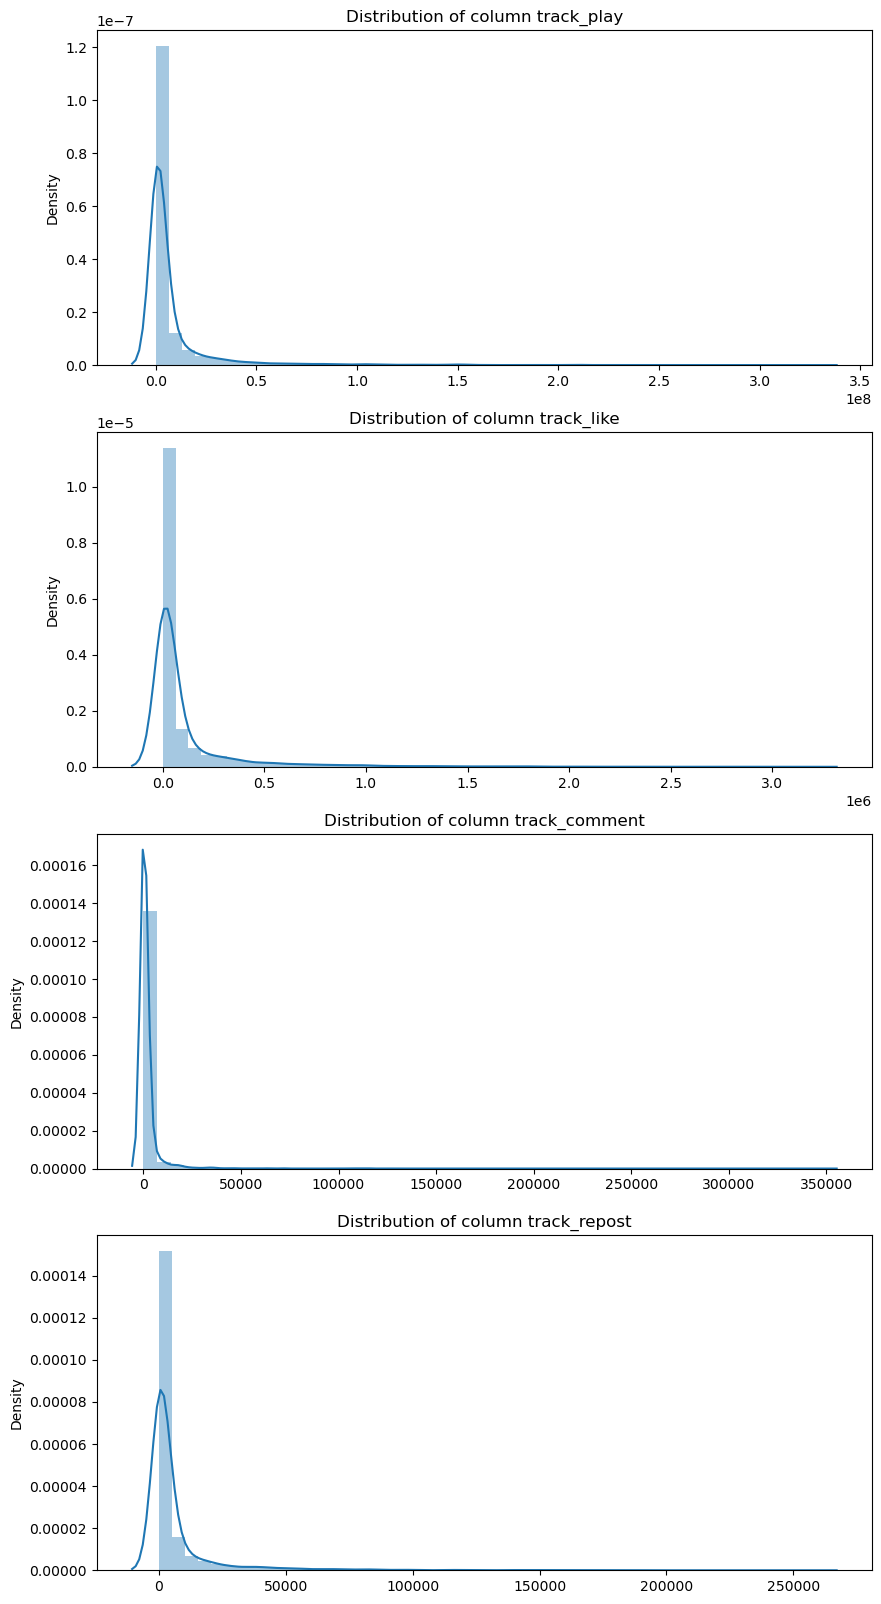

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
axes = axes.ravel()
numeric_cols = track_df.columns[6:10]
for col, ax in zip(numeric_cols, axes):
    sns.distplot(track_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

We can relize that all four features are right skewed **&rarr; Let transform it by log function**

In [17]:
for col in numeric_cols:
    track_df['log_'+ col] = np.log1p(track_df[col])

Visualize again!

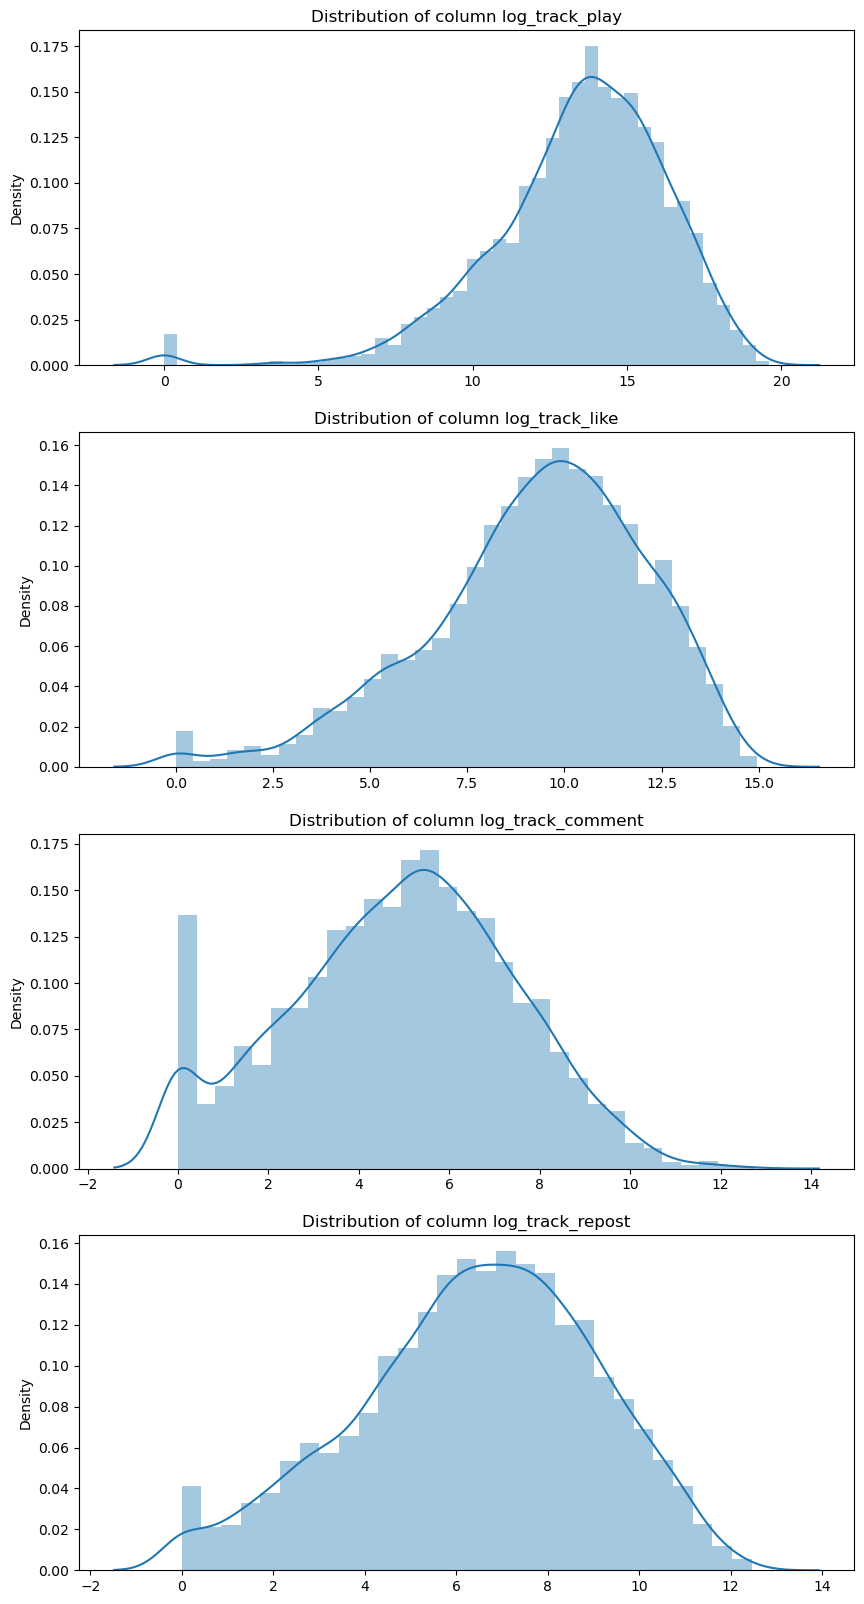

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
axes = axes.ravel()
log_numeric_cols = track_df.columns[10:14]
for col, ax in zip(log_numeric_cols, axes):
    sns.distplot(track_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

Now, we can see that all four plot look like normal distribution **&rarr; We can use normal distribution formula to drop outlier**

#### Outlier (do as same as *user_df*):

In [19]:
upper_limit = []
lower_limit = []
for col in log_numeric_cols:
    upper_limit.append(track_df[col].mean() + 3 * track_df[col].std())
    lower_limit.append(track_df[col].mean() - 3 * track_df[col].std())

condition = (track_df.log_track_play > upper_limit[0]) | (track_df.log_track_play < lower_limit[0]) |\
            (track_df.log_track_like > upper_limit[1]) | (track_df.log_track_like < lower_limit[1]) |\
            (track_df.log_track_comment > upper_limit[2]) | (track_df.log_track_comment < lower_limit[2]) |\
            (track_df.log_track_repost > upper_limit[3]) | (track_df.log_track_repost < lower_limit[3])
track_df[condition]

,track_name,url,user_id,username,datetime,track_tag,track_play,track_like,track_comment,track_repost,log_track_play,log_track_like,log_track_comment,log_track_repost
track_id,,,,,,,,,,,,,,
2282,"The Poets of Rhythm ""Augusta, GA""",https://www.soundcloud.com/daptone-records/the...,982,Daptone Records,2013-09-10 15:41:02+00:00,soul,0,0,0,0,0.0000,0.0000,0.0000,0.0000
22207,02.Igor - Electric Shock,https://www.soundcloud.com/royalgooserecords/0...,1048,RoyalGooseRecords,2014-05-10 22:46:55+00:00,royalgooserecords,30,1,0,0,3.4340,0.6931,0.0000,0.0000
6899,𝙉𝙤. 2 𝙆𝙞𝙡𝙡𝙚𝙧 // 𝘿𝙖𝙫𝙞𝙙 𝙎𝙖𝙣𝙮𝙖,https://www.soundcloud.com/david_sanya/no-2-ki...,1100,𝘾𝙃𝙍𝙄𝙎𝙏𝙈𝘼𝙎,2020-12-09 15:47:00+00:00,R&B & Soul,0,0,0,0,0.0000,0.0000,0.0000,0.0000
5468,𝕳𝕬𝕽𝕯𝕾𝕿𝖄𝕷𝕰,https://www.soundcloud.com/david_sanya/hardstyle,1100,𝘾𝙃𝙍𝙄𝙎𝙏𝙈𝘼𝙎,2022-06-08 20:52:49+00:00,Hardstyle,0,0,0,0,0.0000,0.0000,0.0000,0.0000
16164,Fear is the ruling force in Azerbaijan - Khadi...,https://www.soundcloud.com/amnestyfactual/in-t...,1205,Amnesty Factual,2017-03-31 10:39:30+00:00,News & Politics,143,1,0,0,4.9698,0.6931,0.0000,0.0000
5075,𝘾𝙚𝙧𝙩𝙖𝙞𝙣 // 𝘿𝙖𝙫𝙞𝙙 𝙎𝙖𝙣𝙮𝙖,https://www.soundcloud.com/david_sanya/certain,1100,𝘾𝙃𝙍𝙄𝙎𝙏𝙈𝘼𝙎,2021-07-02 18:10:02+00:00,World,0,0,0,0,0.0000,0.0000,0.0000,0.0000
4939,Be Real,https://www.soundcloud.com/sevnthmusic/be-real,1242,Sevnth,2015-07-17 16:23:38+00:00,Electronic,0,0,0,0,0.0000,0.0000,0.0000,0.0000
10347,MAXX 2║Hard Trap Type Beat Guitar Instrumental...,https://www.soundcloud.com/davidsanyabeats/1-m...,1251,⏬ DᴀᴠɪᴅSᴀɴʏᴀBᴇᴀᴛs.ᴄᴏᴍ║Iɴsᴛʀᴜᴍᴇɴᴛᴀʟ Rᴀᴘ Tʏᴘᴇ Bᴇᴀᴛ,2022-10-04 15:26:37+00:00,R&B & Soul,0,0,0,0,0.0000,0.0000,0.0000,0.0000
23010,12 - PRETTY RICKY- GOTTA CHICK THAT LOVE ME RE...,https://www.soundcloud.com/official-pretty-ric...,1407,Pretty Ricky,2011-08-13 06:21:28+00:00,R&B,0,0,0,0,0.0000,0.0000,0.0000,0.0000


In [20]:
print('Before drop: ', track_df.shape)
print('Number of outliers: ', track_df.loc[condition].shape)
track_df = track_df.loc[~condition]
print('After drop: ', track_df.shape)

Before drop:  (4183, 14)
Number of outliers:  (46, 14)
After drop:  (4137, 14)


Visualize again!

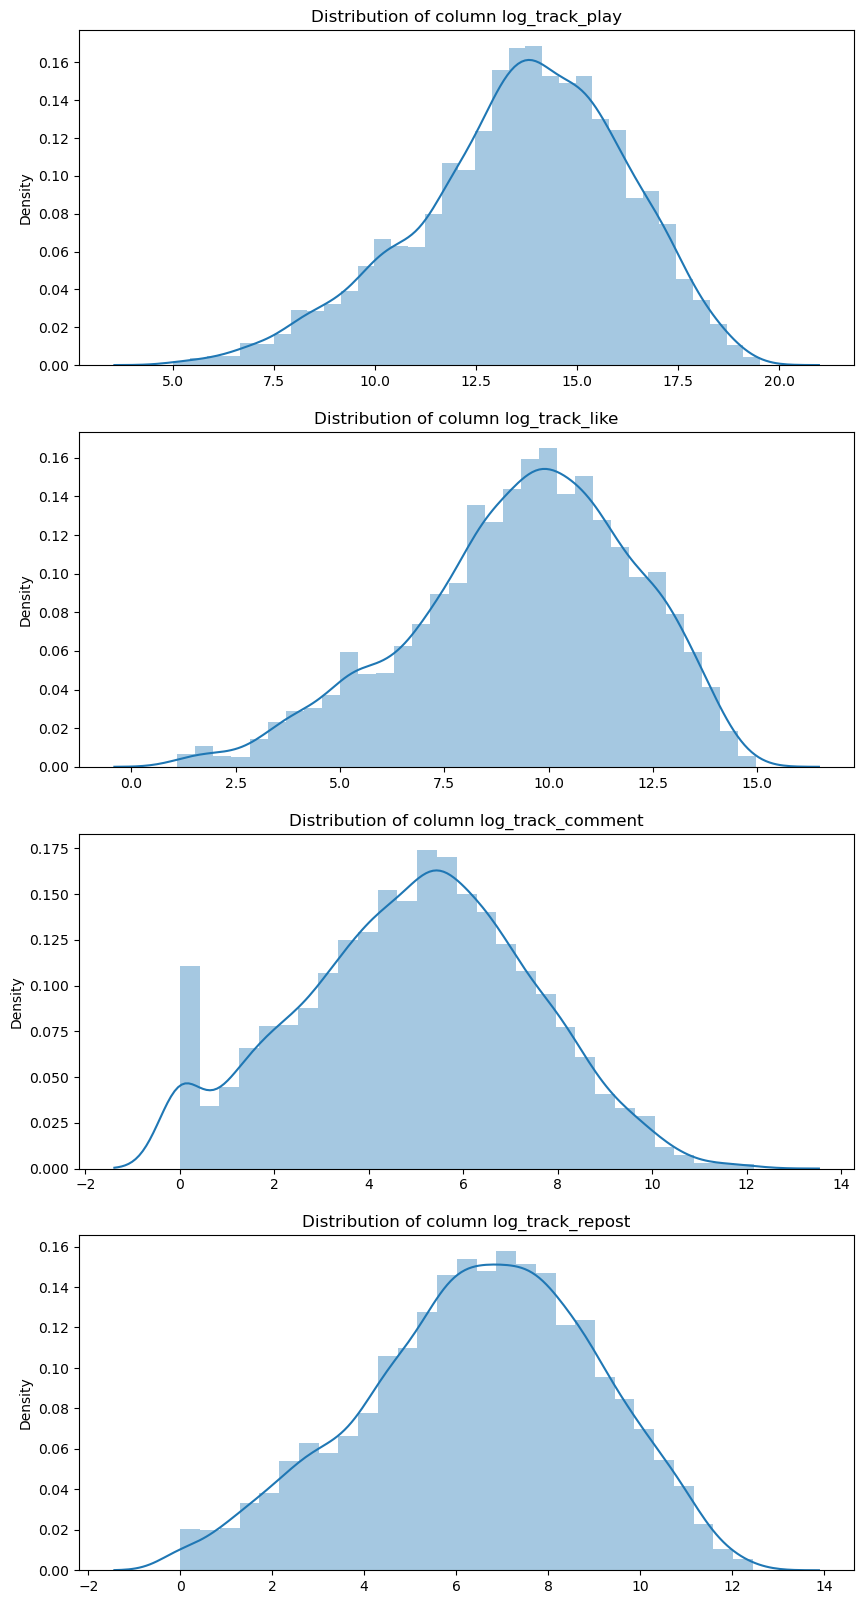

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
axes = axes.ravel()
log_numeric_cols = track_df.columns[10:14]
for col, ax in zip(log_numeric_cols, axes):
    sns.distplot(track_df[col], ax=ax)
    ax.set(title=f'Distribution of column {col}', xlabel=None)

plt.show()

**&rarr; We have dropped almost outliers**

#### What is the most popular track genre?

In [22]:
top_appear = track_df.sort_values('track_tag', ascending=False)
top_appear = top_appear['track_tag'].value_counts().rename_axis('track_tag').reset_index(name='counts')
top_appear = top_appear.drop(top_appear[top_appear['track_tag']=='Missing'].index)
top_appear.head(10)

,track_tag,counts
0,Hip-hop & Rap,327
1,Dance & EDM,103
2,Electronic,99
3,Pop,81
4,Hip Hop,55
5,Trap,51
6,House,47
7,Deep House,46
8,R&B & Soul,41
9,Rap,35


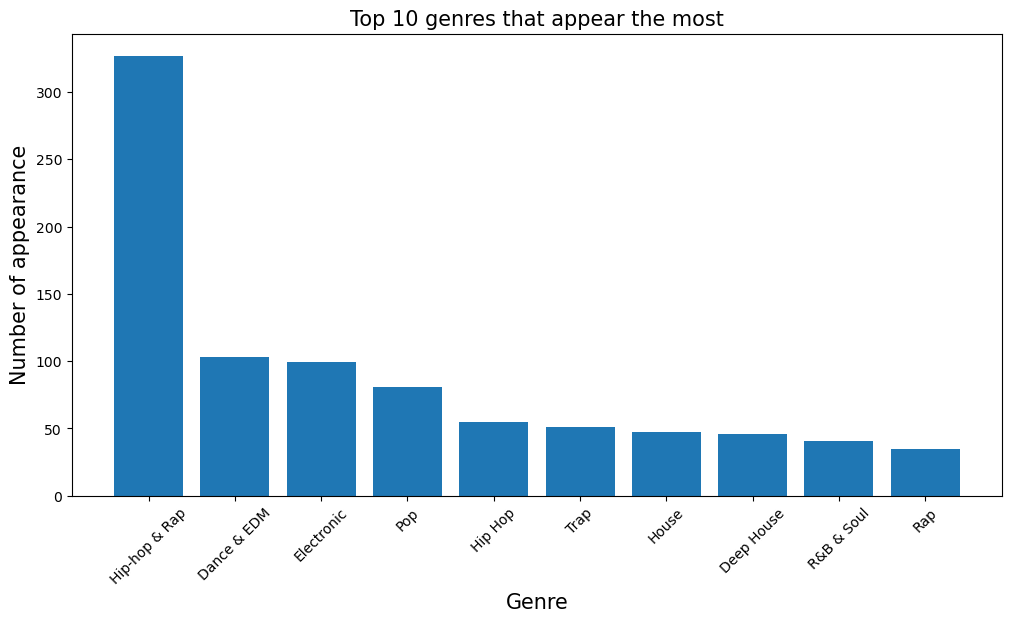

In [23]:
plt.figure(figsize=(12,6))
plt.bar(top_appear.head(10)['track_tag'], top_appear.head(10)['counts'])

plt.xlabel('Genre', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Number of appearance', fontsize=15)
plt.title('Top 10 genres that appear the most', fontsize=15)
plt.show()

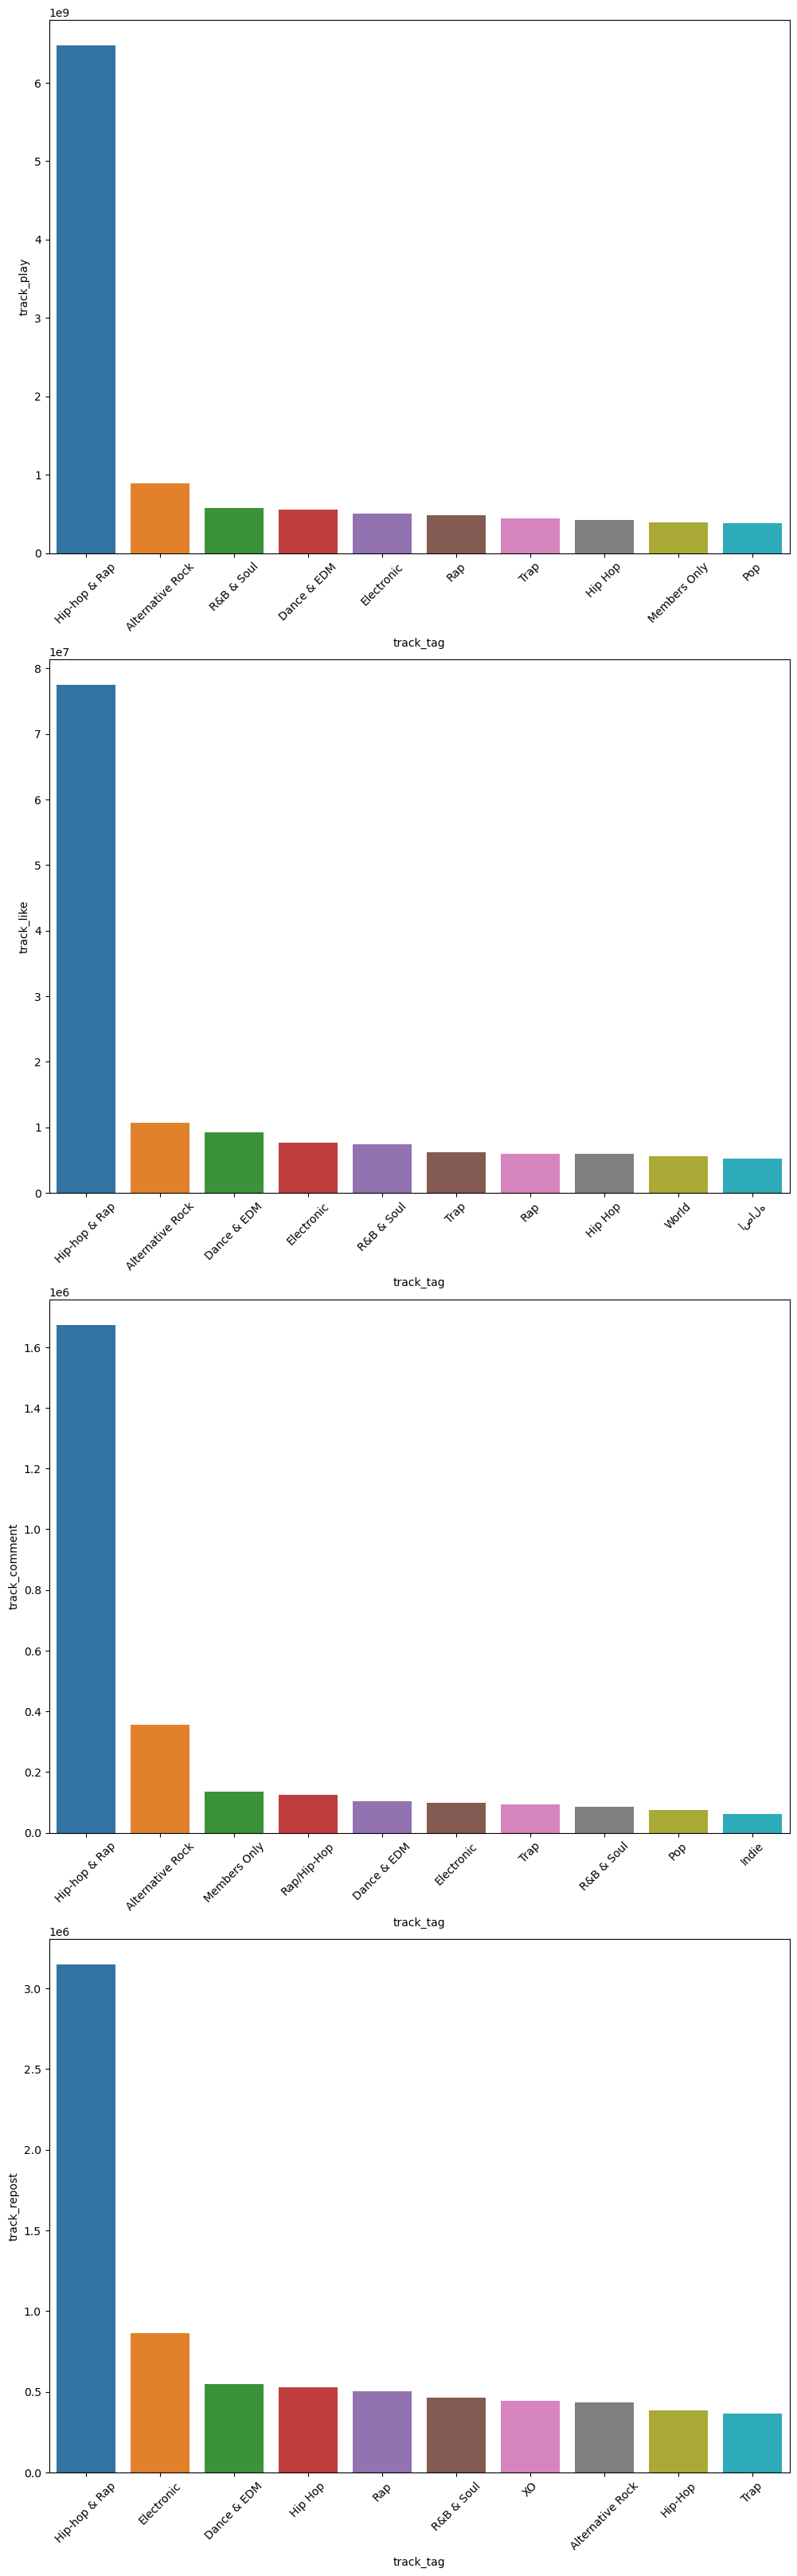

In [24]:
track_play_like_comment_repost = track_df.groupby('track_tag', as_index=False)\
                                            [['track_play', 'track_like', 'track_comment', 'track_repost']].sum()
fig, axes = plt.subplots(4, 1, figsize=(12, 40))

# play
df = track_play_like_comment_repost.groupby('track_tag', as_index=False)['track_play'].sum()\
                                        .sort_values('track_play', ascending=False).head(10)
sns.barplot(df.track_tag, df.track_play, ax=axes[0])

# like
df = track_play_like_comment_repost.groupby('track_tag', as_index=False)['track_like'].sum()\
                                        .sort_values('track_like', ascending=False).head(10)
sns.barplot(df.track_tag, df.track_like, ax=axes[1])

# comment
df = track_play_like_comment_repost.groupby('track_tag', as_index=False)['track_comment'].sum()\
                                        .sort_values('track_comment', ascending=False).head(10)
sns.barplot(df.track_tag, df.track_comment, ax=axes[2])

# repost
df = track_play_like_comment_repost.groupby('track_tag', as_index=False)['track_repost'].sum()\
                                        .sort_values('track_repost', ascending=False).head(10)
sns.barplot(df.track_tag, df.track_repost, ax=axes[3])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.show()

#### What is top 10 favorite track?

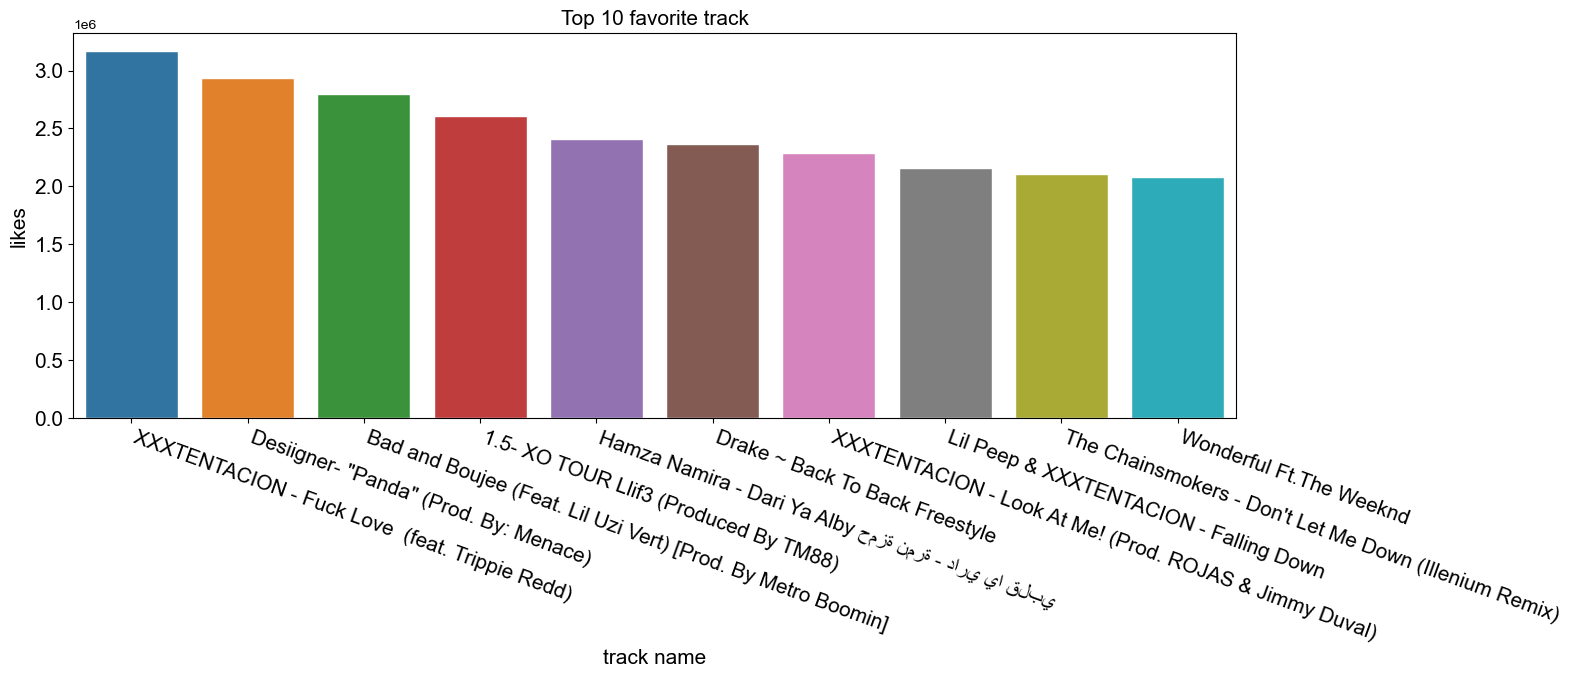

In [25]:
cols = ['track_name', 'track_like']
like_df = track_df.sort_values('track_like', ascending=False)[cols].set_index('track_name')
top_10_like = like_df.head(10)

fig, ax = plt.subplots(figsize=(15,5))
sns.set_style('dark')
sns.barplot(data=top_10_like, x=top_10_like.index, y='track_like');
plt.xticks(ha='left', rotation=-20, fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('track name', fontsize=15); 
plt.ylabel('likes', fontsize=15);
plt.title('Top 10 favorite track', fontsize=15);

#### What is top 10 played track?

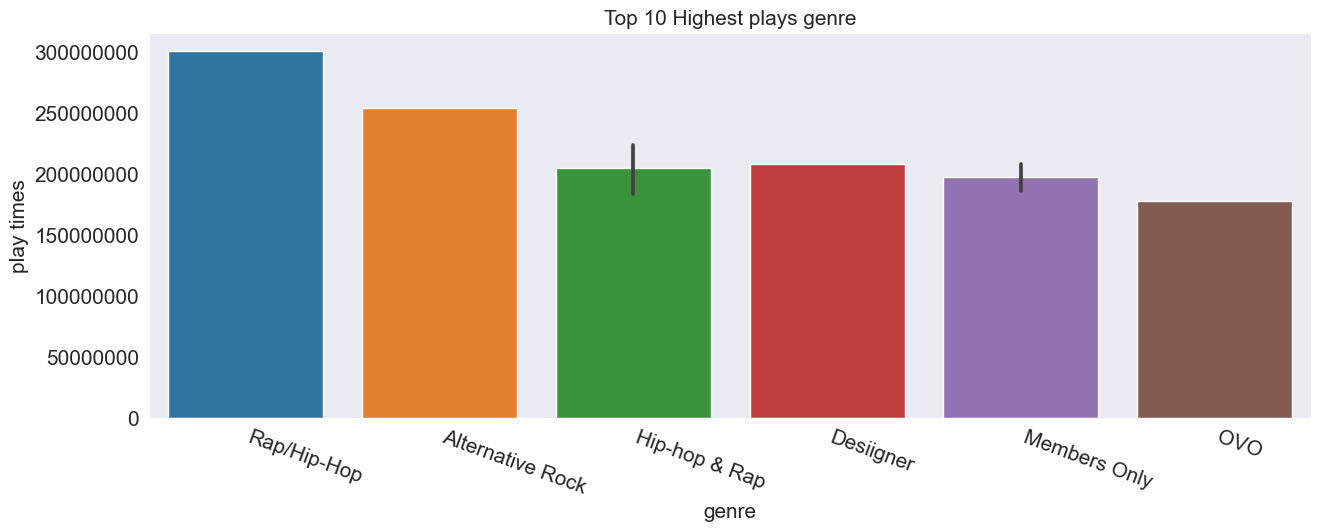

In [26]:
cols = ['track_tag', 'track_play']
play_tag = track_df.sort_values('track_play', ascending=False)[cols].set_index('track_tag')
top_10_play = play_tag.head(10)

fig, ax = plt.subplots(figsize=(15,5))
sns.set_style('dark')
sns.barplot(data=top_10_play, x=top_10_play.index, y='track_play');
plt.xticks(ha='left', rotation=-20, fontsize=15); plt.yticks(fontsize=15)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('genre', fontsize=15);
plt.ylabel('play times', fontsize=15);
plt.title('Top 10 Highest plays genre', fontsize=15);

#### Are the recent popular tracks all new releases?

In [27]:
dates_tracks = track_df['datetime'].squeeze()
dates_tracks = pd.to_datetime(dates_tracks, format='%Y-%m-%d %H:%M:%S')
years = dates_tracks.dt.year

years_tracks = years.value_counts().rename_axis('datetime').reset_index(name='frequency')

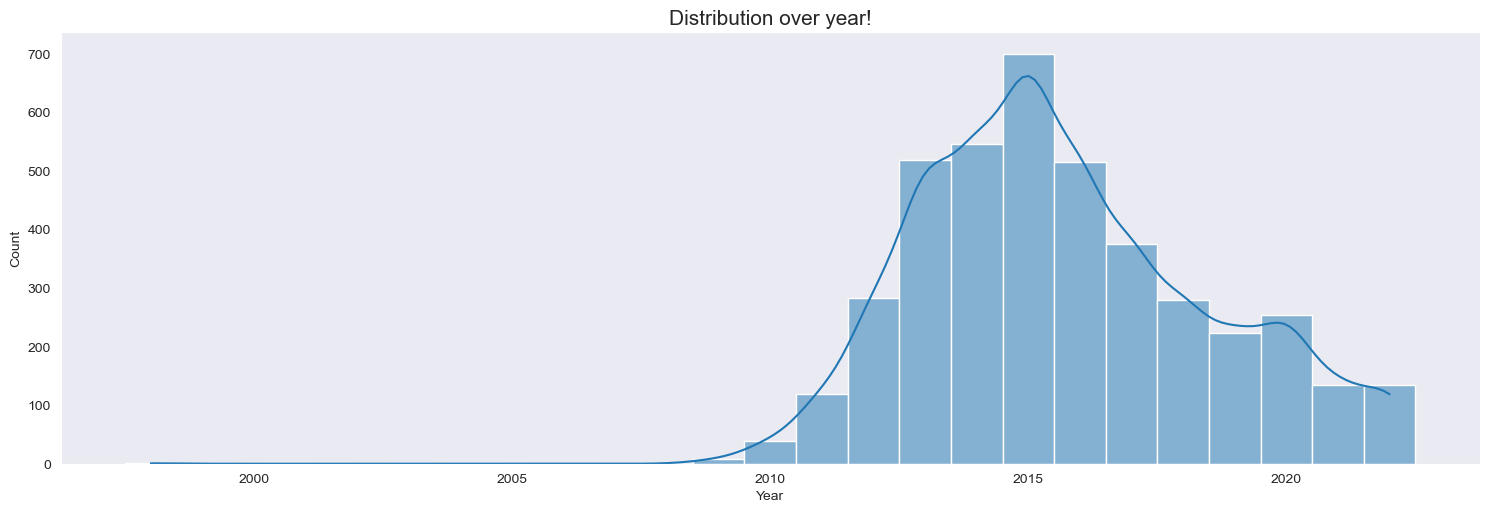

In [28]:
sns.displot(years, discrete=True, aspect=3, kde=True)
plt.xlabel('Year')
plt.title('Distribution over year!', fontsize=15);

**Looking at plot:**
  
- The answer is no. We can easily relize that 2020 tends to decrease to 2022 and has continued to decrease.
- Most tracks were released in 2013, 2014 and 2015. Of which 2015 was the highest.
- 2010 was the year with the fewest uploads.
  

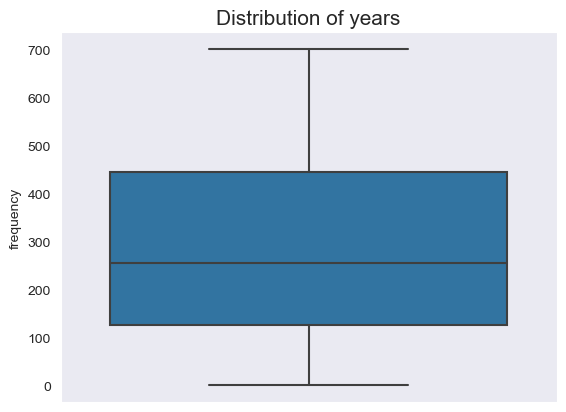

In [29]:
sns.boxplot(y='frequency', data=years_tracks)
plt.title('Distribution of years', fontsize=15);

We can relize:
- Half of the years have more than 78 tracks released.
- 75% of the years have 40 or more tracks released.

#### How do repost tracks affect to number of like, play, and comment?

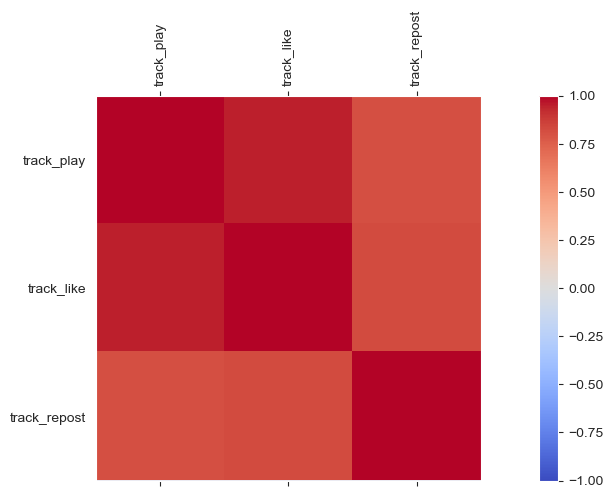

In [30]:
h = track_df[['track_play', 'track_like', 'track_repost']]

corr = h.corr()
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(h.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(h.columns)
ax.set_yticklabels(h.columns)
plt.show()

Looking at plot:
- We can see that the song (track) reposted has an impact on time (track_play) and likes (track_like).
- Moreover, we also see some other correlations.

#### Are likes (track_like), repost (track_repost) and time (track_play) related?

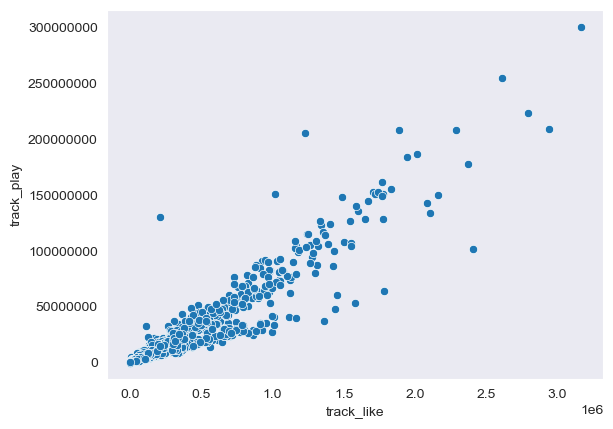

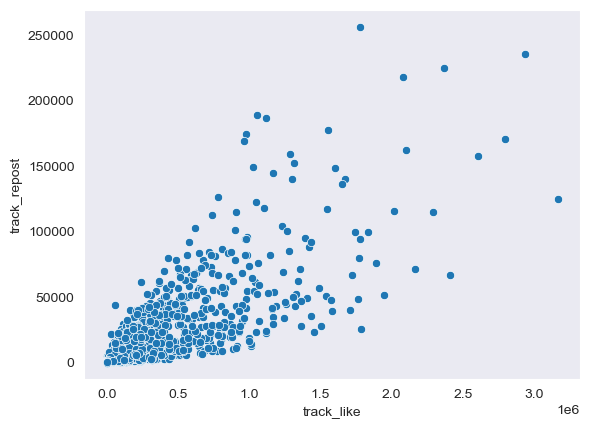

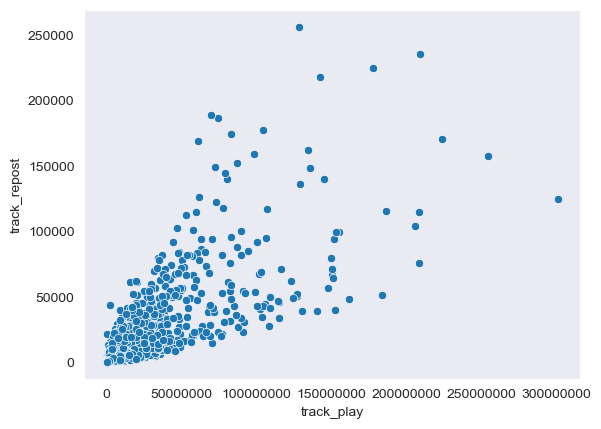

In [31]:
sns.scatterplot(data=h, x="track_like", y="track_play")
plt.ticklabel_format(style='plain', axis='y')
plt.show()
sns.scatterplot(data=h, x="track_like", y="track_repost")
plt.show()
sns.scatterplot(data=h, x="track_play", y="track_repost")
plt.ticklabel_format(style='plain', axis='x')
plt.show()

**Matrix Scatterplot**

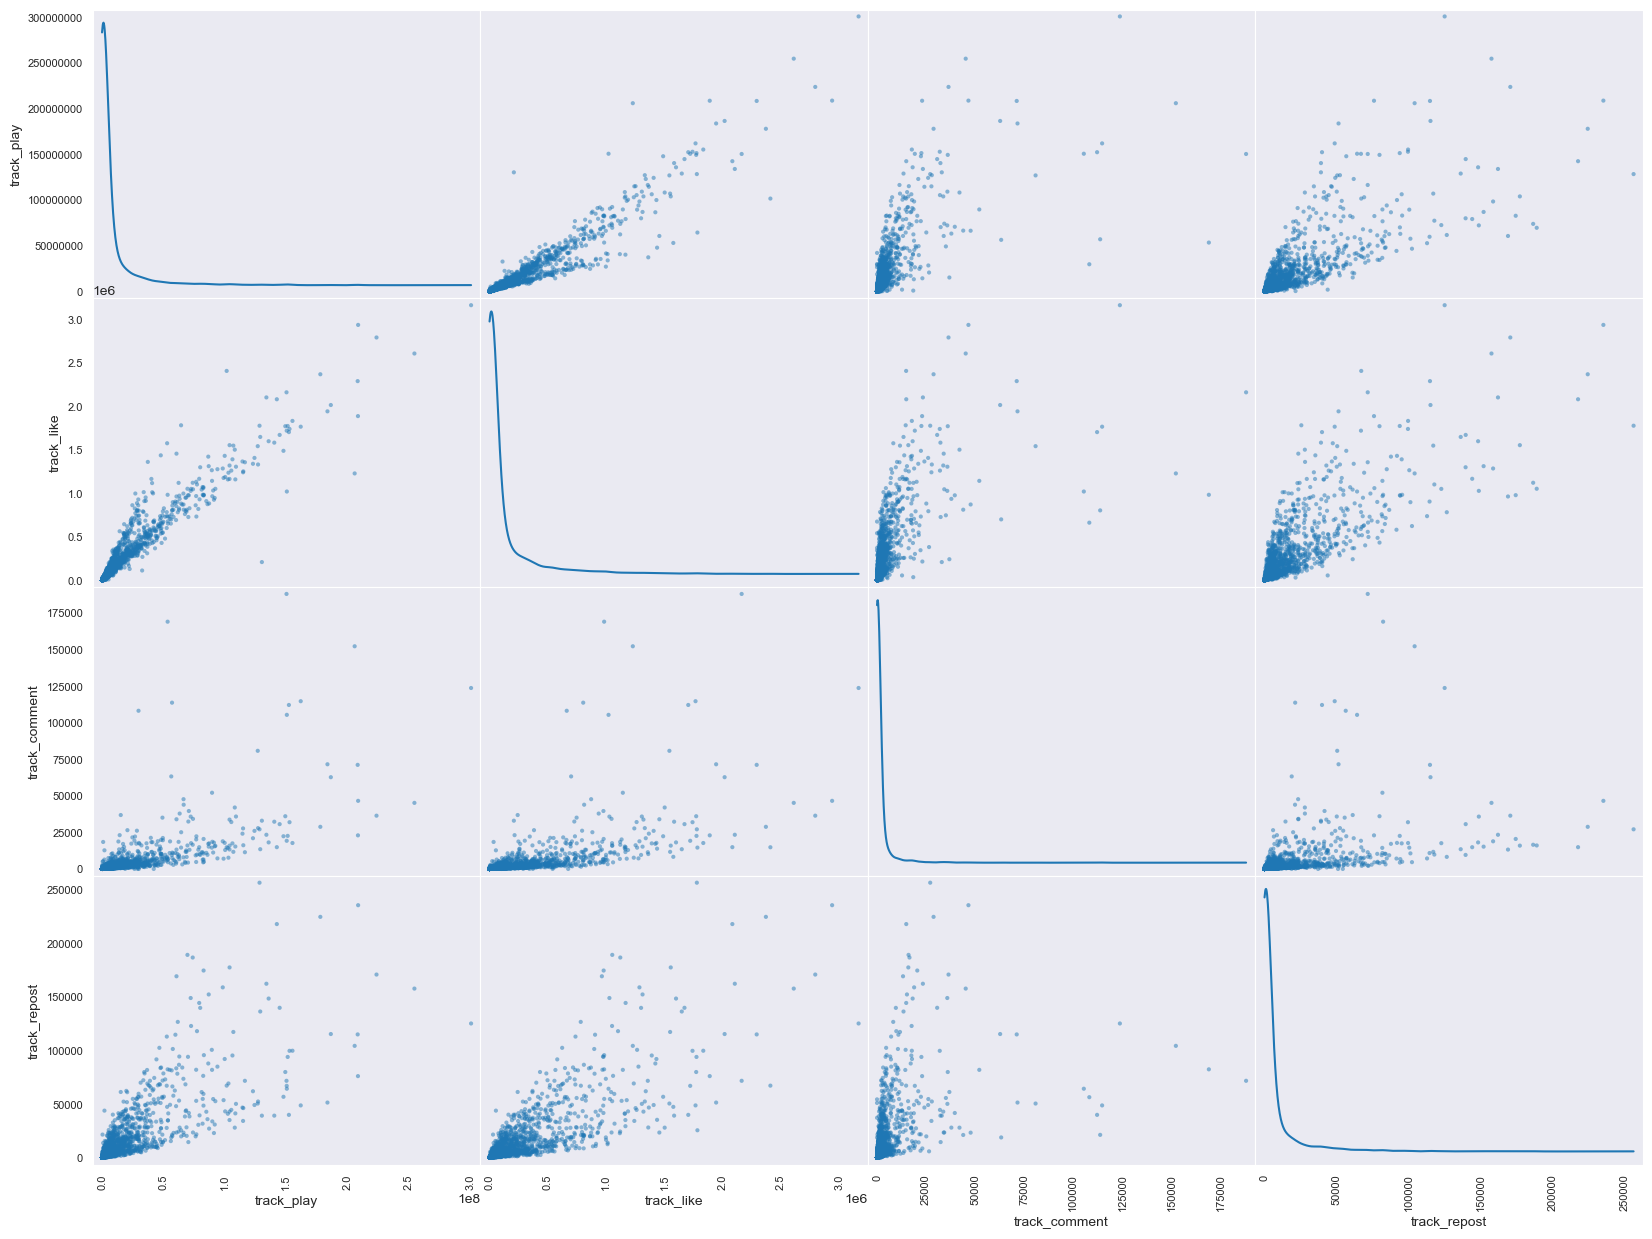

In [33]:
pd.plotting.scatter_matrix(track_df.loc[:, "track_play":"track_repost"], diagonal="kde",figsize=(20,15))
plt.show()

# 3. Reference:

[How SoundCloud Influencers Grow - Data Analysis of 3,000 Publicly Scraped Artist Profiles in Python](https://www.youtube.com/watch?v=zL8ZF7SBWRA)  

[Python Selenium Tutorials](https://www.youtube.com/playlist?list=PLzMcBGfZo4-n40rB1XaJ0ak1bemvlqumQ)
  
[Selenium with Python](https://selenium-python.readthedocs.io/)  
  
[webdriver-manager ](https://pypi.org/project/webdriver-manager/)  
  
[Xử lý các giá trị ngoại lệ](https://machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html)  